# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [2]:
d = 5 
n = 1
sparsity = nCr(n+d, d)

x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.0001#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.1

n_jobs = 20

### number_formulas_load FROM 02 NOTEBOOK
data_size = 2000 #for loading lambda models

#specify interpretation net structure
optimizer = 'adam'
dropout = 0
epochs = 100
batch_size = 128
interpretation_network_layers = [2048]


#lambda net specifications for loading (need to be set according to lambda net training to load correct weights)
epochs_lambda = 200
batch_lambda = 64
lambda_network_layers = [5*sparsity]
optimizer_lambda = '_' + 'SGD'

### lambda_dataset_size FROM 02 NOTEBOOK
lambda_dataset_size = 250

#set if multi_epoch_analysis should be performed
multi_epoch_analysis = True
each_epochs_save_lambda = 10 #None if no checkpointing (otherwise set according to lambda-net training)
epoch_start = 0 #use to skip first epochs in multi_epoch_analysis

#set if samples analysis should be performed
samples_list = None#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 

evaluate_with_real_function = True
consider_labels_training = False



In [3]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 

RANDOM_SEED = 42

advanced_metric_dataset_size = 10#200

same_training_all_polynomials = True


use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''


if same_training_all_polynomials:
    training_string = '_same'
else:
    training_string = '_diverse'

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

structure = '_' + layers_str + str(epochs_lambda) + 'e' + str(batch_lambda) + 'b' + optimizer_lambda
filename = '_shuffleSeedMethod' + '_' + str(RANDOM_SEED) + structure

interpretation_network_string = 'drop' + str(dropout) + 'e' + str(epochs) + 'b' + str(batch_size) + '_' + str(interpretation_network_layers)



In [6]:
### PHILIPP EDIT

# standard deviation specification
standard_deviations = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0, 10.0, 0.0001]
#std_dev = standard_deviations[9]
#filename = filename + '_stdev_' + str(std_dev)

standard_deviations_percentages = [0.0, 0.001, 0.002, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.4, 0.5, 0.75]
#std_dev = standard_deviations_percentages[5]
#filename = filename + '_stdevper_' + str(std_dev)
#DONE: 0, 5, 9, 12

standard_deviations_gradient_per = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2]
#std_dev = standard_deviations_gradient_per[4]
#filename = filename + '_standarddeviationgradient_' + str(std_dev)
# USED: 3, 4

standard_deviations_gradient_per_sup = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2]
#std_dev = standard_deviations_gradient_per_sup[3]
#filename = filename + '_standarddeviationgradient_' + str(std_dev) + '_supplement_'
# USED: 3

standard_deviations_semi_constant_per = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
std_dev = standard_deviations_semi_constant_per[4]
filename = filename + '_standarddeviationrange_' + str(std_dev)
# USED: 3, 4


## Imports

In [7]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

In [8]:
tf.__version__

'2.3.0'

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [10]:
ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)



### Generate List of Monomial Identifiers

In [11]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)



List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']



List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Loss/Error functions

In [12]:
%%script false --no-raise-error
#OLD NOT WORKING CORRECTLY CODE

def calculate_error(input_list):
    true_value = input_list[0]
    pred_value = input_list[1]

    return tf.math.abs(tf.math.subtract(true_value, pred_value))

def true_fn(row_evaluation_set):
    return tf.constant(row_evaluation_set, dtype=tf.float32)

def false_fn(row_evaluation_set):
    return tf.constant([-np.inf for i in range(row_evaluation_set.shape[0])], dtype=tf.float32)


def calculate_mae_fv_lambda_wrapper(valid_data=None, evaluation_set=None):
    
    #row_adjusted_list = []
    #row_adjusted = None
    
    def calculate_mae_fv_lambda(input_list):

        polynomial_true = input_list[0]
        polynomial_pred = input_list[1]

        #nonlocal row_adjusted
        #nonlocal row_adjusted_list
        
        row_adjusted = tf.constant([-np.inf for i in range(evaluation_set.shape[1])])
        
        row_adjusted_list = [row_adjusted]
        
        #time1 = time.time()
        for row_valid_data, row_evaluation_set in zip(valid_data, evaluation_set):
            row_adjusted = tf.cond(tf.reduce_all(tf.equal(polynomial_true, tf.constant(row_valid_data, dtype=tf.float32))), lambda: true_fn(row_evaluation_set), lambda: false_fn(row_evaluation_set))           

            row_adjusted_list = tf.concat([row_adjusted_list, [row_adjusted]], 0)
        #time2 = time.time()
        #print(time2 - time1)
        #time1 = time.time()

        evaluation_results_lambda = tf.reduce_max(row_adjusted_list, axis=0)
        
        global variable_values_valid
        
        for index, variable_values in enumerate(variable_values_valid):
            partial_results = np.array([reduce(lambda x, y: x*y, [single_variable_value**int(coefficient_multiplier) for coefficient_multiplier, single_variable_value in zip(coefficient_multiplier_term, variable_values)]) for coefficient_multiplier_term in list_of_monomial_identifiers], dtype='float32')

            evaluation_result_per_term_pred = tf.vectorized_map(lambda x: x[0]*x[1], (partial_results, polynomial_pred))
            evaluation_result_pred = tf.reduce_sum(evaluation_result_per_term_pred)

            if index == 0:
                evaluation_result_list_pred = tf.convert_to_tensor([evaluation_result_pred])
            else:
                evaluation_result_list_pred = tf.concat([evaluation_result_list_pred, tf.convert_to_tensor([evaluation_result_pred])], 0)
           
        #slim.model_analyzer.analyze_vars([evaluation_result_list_pred], print_info=True)
        
        #time2 = time.time()
        #print(time2 - time1)
        #time1 = time.time()
        
        result = tf.math.reduce_mean(tf.vectorized_map(calculate_error, (evaluation_results_lambda, evaluation_result_list_pred)))
        #time2 = time.time()
        #print(time2 - time1)
        
        #slim.model_analyzer.analyze_vars([result], print_info=True)


        return result
    return calculate_mae_fv_lambda

def mean_absolute_error_tf_fv_lambda_wrapper(valid_data=None, evaluation_set=None):
    
    def mean_absolute_error_tf_fv_lambda(y_true, y_pred):
        
        #time1 = time.time()
        result_1 = tf.vectorized_map(calculate_mae_fv_lambda_wrapper(valid_data=valid_data, evaluation_set=evaluation_set), (y_true, y_pred))
        #time2 = time.time()
        #print('L1 ' + str(time2 - time1))
        time1 = time.time()
        
        #print(result_1)
        
        result = tf.math.reduce_mean(result_1)
        time2 = time.time()
        #print('L1 ' + str(time2 - time1))
        return result#tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv_lambda_wrapper(valid_data=valid_data, evaluation_set=evaluation_set), (y_true, y_pred)))
    
    return mean_absolute_error_tf_fv_lambda


In [13]:
%%script false --no-raise-error

array_1 = y_train.iloc[0].values
array_2 = y_train.iloc[0].values + 0.1


tensor_1 = tf.constant([array_1, array_1], dtype=tf.float32)
tensor_2 = tf.constant([array_1, array_1], dtype=tf.float32)

result1 = mean_absolute_error_tf_fv_lambda_wrapper(valid_data=y_train[:500].values, evaluation_set=pred_evaluation_dataset_valid_train_split[:500].values)(tensor_1, tensor_2)
print('OUTSIDE ' + str(time.time()))
print('Tensor Computation ' + str(result1.numpy()))


result2 = mean_absolute_error(calculate_function_values_from_polynomial(y_train.iloc[0].values, y_train.iloc[0].values, variable_values_valid)[0], pred_evaluation_dataset_valid_train_split.values[0])

print('Standatd Computation ' + str(result2))




In [14]:
def calculate_partial_results(variable_values):

    global list_of_monomial_identifiers
    
    partial_results = np.array([sum([single_variable_value**int(coefficient_multiplier) for coefficient_multiplier, single_variable_value in zip(coefficient_multiplier_term, variable_values)]) for coefficient_multiplier_term in list_of_monomial_identifiers], dtype='float32')
        
    return partial_results#tf.math.abs(tf.math.subtract(evaluation_result_true, evaluation_result_pred))
    
def calculate_mae_fv(polynomial_true_pred):
    polynomial_true = polynomial_true_pred[0]
    polynomial_pred = polynomial_true_pred[1]
    
    global variable_values_valid
    
    for index, variable_values in enumerate(variable_values_valid):

        partial_results = np.array([reduce(lambda x, y: x*y, [single_variable_value**int(coefficient_multiplier) for coefficient_multiplier, single_variable_value in zip(coefficient_multiplier_term, variable_values)]) for coefficient_multiplier_term in list_of_monomial_identifiers], dtype='float32')
            
        evaluation_result_per_term_true = tf.vectorized_map(lambda x: x[0]*x[1], (partial_results, polynomial_true))
        evaluation_result_true = tf.reduce_sum(evaluation_result_per_term_true)

        evaluation_result_per_term_pred = tf.vectorized_map(lambda x: x[0]*x[1], (partial_results, polynomial_pred))
        evaluation_result_pred = tf.reduce_sum(evaluation_result_per_term_pred)
        
        if index == 0:   
            result = tf.math.abs(tf.math.subtract(evaluation_result_true, evaluation_result_pred))
        else:           
            current_valiue = tf.math.abs(tf.math.subtract(evaluation_result_true, evaluation_result_pred))
            result = tf.math.add(result, current_valiue)    
            
    return  tf.math.divide(result, variable_values_test.shape[0]) #tf.random.uniform(shape=[1], minval=0.1, maxval=10.0)

def calculate_mae_single_input(input_list):
    true_value = input_list[0]
    pred_value = input_list[1]

    return tf.math.abs(tf.math.subtract(true_value, pred_value))

def calculate_mae_fv_lambda(input_list):
    
    polynomial_true = input_list[0]
    polynomial_pred = input_list[1]
    evaluation_results_lambda = input_list[2]

    global variable_values_valid

    for index, variable_values in enumerate(variable_values_valid):
        partial_results = np.array([reduce(lambda x, y: x*y, [single_variable_value**int(coefficient_multiplier) for coefficient_multiplier, single_variable_value in zip(coefficient_multiplier_term, variable_values)]) for coefficient_multiplier_term in list_of_monomial_identifiers], dtype='float32')

        evaluation_result_per_term_pred = tf.vectorized_map(lambda x: x[0]*x[1], (partial_results, polynomial_pred))
        evaluation_result_pred = tf.reduce_sum(evaluation_result_per_term_pred)

        if index == 0:
            evaluation_result_list_pred = tf.convert_to_tensor([evaluation_result_pred])
        else:
            evaluation_result_list_pred = tf.concat([evaluation_result_list_pred, tf.convert_to_tensor([evaluation_result_pred])], 0)


    return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (evaluation_results_lambda, evaluation_result_list_pred)))
    
def mean_absolute_error_tf_fv_lambda_extended(y_true, y_pred):

    evaluation_results_lambda = y_true[:,sparsity:]
    y_true = y_true[:,:sparsity]

    return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv_lambda, (y_true, y_pred, evaluation_results_lambda)))


def mean_absolute_error_extended(y_true, y_pred): 
    y_true = y_true[:,:sparsity]
    return tf.keras.losses.MAE(y_true, y_pred)

def mean_absolute_error_tf_fv(y_true, y_pred):
    return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv, (y_true, y_pred)))

def mean_absolute_error_tf_fv_lambda_extended(y_true, y_pred):   
    y_true = y_true[:,:sparsity]
    return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv, (y_true, y_pred)))



def root_mean_squared_error(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
            
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    if 'float' in str(y_true[0].dtype):        
        if tf.is_tensor(y_true):
            y_true = tf.dtypes.cast(y_true, tf.float32) 
        else:
            y_true = y_true.astype('float32')
        if tf.is_tensor(y_pred):
            y_pred = tf.dtypes.cast(y_pred, tf.float32)
        else:
            y_pred = y_pred.astype('float32')
            
        n_digits = int(-np.log10(a_step))
        
        y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
        y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    if 'float' in str(y_true[0].dtype):        
        if tf.is_tensor(y_true):
            y_true = tf.dtypes.cast(y_true, tf.float32) 
        else:
            y_true = y_true.astype('float32')
        if tf.is_tensor(y_pred):
            y_pred = tf.dtypes.cast(y_pred, tf.float32)
        else:
            y_pred = y_pred.astype('float32')
            
        n_digits = int(-np.log10(a_step))
        
        y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
        y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values    
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
        
    epsilon = tf.convert_to_tensor(epsilon)
    epsilon = tf.dtypes.cast(epsilon, tf.float32)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

In [15]:
def calcualate_function_with_data(coefficient_list, variable_values):
    
    result = 0   
    
    #print(coefficient_list)
    #print(list_of_constants)
    
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        partial_results = [variable_value**int(coefficient_multiplier) for coefficient_multiplier, variable_value in zip(coefficient_multipliers, variable_values)]
        #print(partial_results)
        result += coefficient_value * reduce(lambda x, y: x*y, partial_results)

        #print(coefficient_value)
    #print(result)
    return result, np.append(variable_values, result)

def calculate_function_values_from_polynomial(true_value, pred_value, evaluation_dataset):
    
    if isinstance(true_value, pd.DataFrame):
        true_value = true_value.values
    if isinstance(pred_value, pd.DataFrame):
        pred_value = pred_value.values
        
    true_value_fv = []
    pred_value_fv = []
    
    true_value_fv_with_variable_values = []
    pred_value_fv_with_variable_values = []
    
        
    for evaluation in evaluation_dataset:
        true_function_value, true_function_value_with_variable_values = calcualate_function_with_data(true_value, evaluation)
        pred_function_value, pred_function_value_with_variable_values = calcualate_function_with_data(pred_value, evaluation)
        
        true_value_fv.append(true_function_value)
        pred_value_fv.append(pred_function_value)
        
        true_value_fv_with_variable_values.append(true_function_value_with_variable_values)
        pred_value_fv_with_variable_values.append(pred_function_value_with_variable_values)

    return true_value_fv, pred_value_fv, true_value_fv_with_variable_values, pred_value_fv_with_variable_values


def mean_absolute_error_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
       
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
     
    result_array = np.array(result_list)
                
    #error value calculation    
    result = np.mean(result_array)  
    
    
    #error value calculation    
    #result = np.mean(np.abs(y_true-y_pred))
    
    
    
    
    return result

def root_mean_squared_error_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values      
     
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sqrt(np.mean((true_values-pred_values)**2)))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)     
    
    #error value calculation    
    #result = np.sqrt(np.mean((y_true-y_pred)**2))
    
    return result

def mean_absolute_percentage_error_function_values(y_true, y_pred, epsilon=10e-3):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
     
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(((true_values-pred_values)/(true_values+epsilon)))))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)    
       
    #error value calculation    
    #result = np.mean(np.abs(((y_true-y_pred)/(y_true+epsilon))))
        
    
    return result

def r2_score_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)     
    
    #error value calculation    
    #result = r2_score(y_true, y_pred)
    
    return result

def relative_absolute_average_error_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    result_list = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sum(np.abs(true_values-pred_values))/(true_values.shape[0]*np.std(true_values)))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)       
    
    #error value calculation    
    #result = np.sum(np.abs(y_true-y_pred))/(evaluation_size*np.std(y_true))
    #np.sum(np.abs(y_true-y_pred))/(evaluation_size*np.std(y_true)) #correct STD?
    
    return result

def relative_maximum_average_error_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.max(true_values-pred_values)/np.std(true_values))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)   
    
    
    #error value calculation    
    #result = np.max(y_true-y_pred)/np.std(y_true) #correct STD?
    
    return result

def mean_area_between_two_curves_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
      
    assert(number_of_variables==1)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(area_between_two_curves(true_values, pred_values))
     
    result_array = np.array(result_list)
        
    #error value calculation    
    result = np.mean(result_array)    
    return result

def mean_dtw_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        

    result_list_single = []
    result_list_array = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_single_value, result_single_array = dtw(true_values, pred_values)
        result_list_single.append(result_single_value)
        result_list_array.append(result_single_array)
     
    result_array_value = np.array(result_list_single)  
    result_array_array = np.array(result_list_array)  
               
    #error value calculation    
    result_value = np.mean(result_array_value)
    result_array = np.mean(result_array_array, axis=1)
    
    return result_value, result_array

def mean_frechet_dist_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(frechet_dist(true_values, pred_values))
     
    result_array = np.array(result_list)
                
    #error value calculation    
    result = np.mean(result_array)
    
    return result


## Load Data and Generate Datasets

In [16]:
def load_data(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str((index+1)*each_epochs_save_lambda).zfill(3) + filename + '.txt'

    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=[i for i in range(nCr(n+d, d))]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    return weight_data
    

In [17]:
#LOAD DATA
if multi_epoch_analysis:  
    weight_data_list = []
    
    foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    weight_data_list = parallel(delayed(load_data)(index) for index in range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda))  
    del parallel
    
    weight_data = weight_data_list[-1]
else:

    foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
                
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3) + filename + '.txt'

    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=[i for i in range(nCr(n+d, d))]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        

    

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:   15.8s remaining:  2.4min
[Parallel(n_jobs=20)]: Done   9 out of  20 | elapsed:   16.1s remaining:   19.6s
[Parallel(n_jobs=20)]: Done  16 out of  20 | elapsed:   16.2s remaining:    4.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   16.2s finished


In [18]:
if multi_epoch_analysis == False:
    path_pred_evaluation_dataset_lambda_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_' + 'epoch_' + str(epochs_lambda//each_epochs_save_lambda-1).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_lambda_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_' + 'epoch_' + str(epochs_lambda//each_epochs_save_lambda-1).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_lambda_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_' + 'epoch_' + str(epochs_lambda//each_epochs_save_lambda-1).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'

    pred_evaluation_dataset_lambda_train = pd.read_csv(path_pred_evaluation_dataset_lambda_train, sep=',')
    pred_evaluation_dataset_lambda_valid = pd.read_csv(path_pred_evaluation_dataset_lambda_valid, sep=',')
    pred_evaluation_dataset_lambda_test = pd.read_csv(path_pred_evaluation_dataset_lambda_test, sep=',') 
    
    pred_evaluation_dataset_lambda_train = pred_evaluation_dataset_lambda_train.sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
    pred_evaluation_dataset_lambda_valid = pred_evaluation_dataset_lambda_valid.sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
    pred_evaluation_dataset_lambda_test = pred_evaluation_dataset_lambda_test.sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
           
    variable_values_train = []
    for column in pred_evaluation_dataset_lambda_train.columns:
        variable_values_train.append(np.array(column[1:-1].split()).astype('float'))
    variable_values_train = np.array(variable_values_train)
    
    variable_values_valid = []
    for column in pred_evaluation_dataset_lambda_valid.columns:
        variable_values_valid.append(np.array(column[1:-1].split()).astype('float'))
    variable_values_valid = np.array(variable_values_valid)

    variable_values_test = []
    for column in pred_evaluation_dataset_lambda_test.columns:
        variable_values_test.append(np.array(column[1:-1].split()).astype('float'))
    variable_values_test  = np.array(variable_values_test)

else:
    pred_evaluation_dataset_train_list = []
    pred_evaluation_dataset_valid_list = []
    pred_evaluation_dataset_test_list = []
    variable_values_train_list = []
    variable_values_valid_list = []
    variable_values_test_list = []
    for index in tqdm(range(epochs_lambda//each_epochs_save_lambda)):    
        path_pred_evaluation_dataset_lambda_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_lambda_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_lambda_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'

        pred_evaluation_dataset_lambda_train = pd.read_csv(path_pred_evaluation_dataset_lambda_train, sep=',')
        pred_evaluation_dataset_lambda_valid = pd.read_csv(path_pred_evaluation_dataset_lambda_valid, sep=',')
        pred_evaluation_dataset_lambda_test = pd.read_csv(path_pred_evaluation_dataset_lambda_test, sep=',')     
        
        pred_evaluation_dataset_lambda_train = pred_evaluation_dataset_lambda_train.sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
        pred_evaluation_dataset_lambda_valid = pred_evaluation_dataset_lambda_valid.sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
        pred_evaluation_dataset_lambda_test = pred_evaluation_dataset_lambda_test.sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
  
        pred_evaluation_dataset_train_list.append(pred_evaluation_dataset_lambda_train)
        pred_evaluation_dataset_valid_list.append(pred_evaluation_dataset_lambda_valid)
        pred_evaluation_dataset_test_list.append(pred_evaluation_dataset_lambda_test)

        if not same_training_all_polynomials:
            variable_values_train = []
            for column in pred_evaluation_dataset_lambda_train.columns:
                variable_values_train.append(np.array(column[1:-1].split()).astype('float'))
            variable_values_train = np.array(variable_values_train)
            variable_values_train_list.append(variable_values_train)
            
            variable_values_valid = []
            for column in pred_evaluation_dataset_lambda_valid.columns:
                variable_values_valid.append(np.array(column[1:-1].split()).astype('float'))
            variable_values_valid = np.array(variable_values_valid)
            variable_values_valid_list.append(variable_values_valid)

            variable_values_test = []
            for column in pred_evaluation_dataset_lambda_test.columns:
                variable_values_test.append(np.array(column[1:-1].split()).astype('float'))
            variable_values_test  = np.array(variable_values_test)
            variable_values_test_list.append(variable_values_test)
    if same_training_all_polynomials:
        variable_values_train = []
        for column in pred_evaluation_dataset_lambda_train.columns:
            variable_values_train.append(np.array(column[1:-1].split()).astype('float'))
        variable_values_train = np.array(variable_values_train)
        
        variable_values_valid = []
        for column in pred_evaluation_dataset_lambda_valid.columns:
            variable_values_valid.append(np.array(column[1:-1].split()).astype('float'))
        variable_values_valid = np.array(variable_values_valid)

        variable_values_test = []
        for column in pred_evaluation_dataset_lambda_test.columns:
            variable_values_test.append(np.array(column[1:-1].split()).astype('float'))
        variable_values_test  = np.array(variable_values_test)


## Data Inspection

In [19]:
weight_data.head()

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,8.600,-0.200,-1.100,0.900,-2.000,-6.500,8.126,-1.518,-0.097,-0.134,...,-0.342,0.315,0.822,0.784,0.272,0.174,0.797,0.506,0.911,1.610
1,-6.400,-3.400,-7.100,-2.000,-8.900,-6.800,-9.222,-1.836,-0.126,-0.062,...,-1.368,-0.138,0.379,0.360,0.035,0.085,0.245,0.240,0.343,-2.100
2,3.800,-6.700,-4.800,6.700,-6.500,4.800,1.763,-1.317,-0.583,0.659,...,-0.445,0.073,0.411,0.394,0.153,0.056,0.485,0.139,0.505,0.677
3,-0.700,-1.500,-6.500,-6.900,-4.900,1.200,-2.295,-1.544,-0.769,1.053,...,-0.742,-0.052,0.379,0.360,0.039,0.084,0.229,0.234,0.343,-1.224
4,3.300,2.400,6.000,-3.900,-3.000,1.200,3.980,1.371,2.400,-1.032,...,-0.332,0.394,0.656,0.623,0.239,0.233,0.481,0.760,0.620,1.255


In [20]:
pred_evaluation_dataset_lambda_test.head()

,[0.7519],[-0.895],[-0.7493],[0.7231],[0.2489],[-0.2773],[-0.6042],[-0.4527],[-0.9121],[-0.1718],...,[-0.1789],[-0.9409],[0.8878],[-0.2839],[0.7442],[-0.339],[0.0628],[-0.4255],[0.4485],[-0.8763]
0,6.918,9.516,9.274,6.965,7.744,8.544,9.039,8.810,9.544,8.383,...,8.394,9.592,6.708,8.554,6.931,8.638,8.027,8.769,7.418,9.485
1,-10.707,-7.641,-7.894,-10.645,-9.692,-8.719,-8.147,-8.410,-7.611,-8.910,...,-8.897,-7.561,-10.998,-8.707,-10.691,-8.608,-9.341,-8.458,-10.070,-7.673
2,0.710,2.411,2.334,0.749,1.399,2.084,2.257,2.177,2.420,2.010,...,2.018,2.436,0.528,2.088,0.720,2.117,1.665,2.163,1.124,2.401
3,-3.532,-1.774,-1.795,-3.485,-2.714,-1.931,-1.815,-1.836,-1.772,-2.048,...,-2.040,-1.768,-3.751,-1.924,-3.519,-1.863,-2.412,-1.840,-3.039,-1.777
4,5.687,4.274,4.167,5.619,4.498,3.821,4.061,3.950,4.287,3.743,...,3.748,4.308,6.009,3.826,5.669,3.866,4.058,3.930,4.970,4.261


In [21]:
pred_evaluation_dataset_lambda_valid.head()

,[-0.3704],[0.1046],[0.0168],[0.2732],[-0.3235],[0.2604],[0.0718],[0.3082],[0.2895],[0.209],...,[0.0719],[-0.4499],[-0.348],[-0.0854],[-0.7747],[0.601],[0.5002],[-0.0436],[0.5557],[-0.687]
0,8.686,7.963,8.097,7.706,8.615,7.726,8.013,7.649,7.680,7.805,...,8.013,8.806,8.652,8.252,9.316,7.167,7.333,8.188,7.241,9.171
1,-8.553,-9.420,-9.254,-9.738,-8.635,-9.714,-9.358,-9.804,-9.769,-9.617,...,-9.358,-8.415,-8.592,-9.066,-7.850,-10.383,-10.168,-9.142,-10.286,-8.003
2,2.134,1.604,1.733,1.365,2.109,1.383,1.652,1.317,1.343,1.455,...,1.651,2.176,2.122,1.884,2.348,0.916,1.054,1.822,0.978,2.301
3,-1.848,-2.480,-2.337,-2.754,-1.880,-2.733,-2.426,-2.811,-2.780,-2.649,...,-2.427,-1.837,-1.853,-2.171,-1.791,-3.286,-3.123,-2.239,-3.213,-1.803
4,3.889,4.157,3.949,4.555,3.855,4.525,4.079,4.638,4.594,4.404,...,4.080,3.947,3.873,3.750,4.186,5.330,5.092,3.814,5.223,4.122


In [22]:
weight_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,...,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,0.176,0.389,0.144,-0.108,-0.113,0.005,0.144,0.536,0.444,-0.043,...,-0.696,0.112,0.615,0.583,0.156,0.156,0.493,0.473,0.577,-0.169
std,5.835,5.695,5.821,5.799,5.734,5.702,6.028,6.199,1.435,2.004,...,0.437,0.334,0.259,0.244,0.143,0.084,0.313,0.273,0.265,1.335
min,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-12.602,-15.783,-5.006,-8.734,...,-1.985,-0.535,0.357,0.341,-0.019,0.054,0.148,0.121,0.341,-2.247
25%,-4.900,-4.500,-5.100,-5.200,-5.100,-4.900,-5.213,-4.329,-0.484,-0.763,...,-1.054,-0.169,0.379,0.360,0.034,0.085,0.245,0.240,0.343,-1.492
50%,0.200,0.600,0.200,0.100,-0.100,-0.100,0.306,0.549,0.196,0.000,...,-0.434,0.076,0.519,0.492,0.103,0.122,0.345,0.359,0.463,-0.119
75%,5.300,5.400,5.400,4.800,4.800,4.900,5.369,5.443,1.266,0.604,...,-0.332,0.386,0.823,0.780,0.253,0.213,0.684,0.663,0.774,1.187
max,9.900,9.900,9.900,9.900,9.900,9.900,12.014,15.347,6.348,8.484,...,-0.330,0.887,1.514,1.427,0.595,0.444,1.572,1.387,1.444,1.856


## Generate Datasets for Interpretation-Net training

In [23]:
#generate train, test and validation data for training
if multi_epoch_analysis:    
    X_train_list = []
    y_train_with_formula_list = []
    y_train_list = []
    
    X_valid_list = []
    y_valid_with_formula_list = []
    y_valid_list = []
    
    X_test_list = []
    y_test_with_formula_list = []
    y_test_list = []
    
    pred_evaluation_dataset_test_valid_split_list = []
    pred_evaluation_dataset_test_test_split_list = []
    pred_evaluation_dataset_test_train_split_list = []
    
    pred_evaluation_dataset_valid_valid_split_list = []
    pred_evaluation_dataset_valid_test_split_list = []
    pred_evaluation_dataset_valid_train_split_list = []
    
    pred_evaluation_dataset_train_valid_split_list = []
    pred_evaluation_dataset_train_test_split_list = []
    pred_evaluation_dataset_train_train_split_list = []

    
    for weight_data, pred_evaluation_dataset_train, pred_evaluation_dataset_valid, pred_evaluation_dataset_test in tqdm(zip(weight_data_list, pred_evaluation_dataset_train_list, pred_evaluation_dataset_valid_list, pred_evaluation_dataset_test_list), total=len(weight_data_list)): 
        
        if psutil.virtual_memory().percent > 80:
            raise SystemExit("Out of RAM!")
        
        X_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED).drop([i for i in range(nCr(n+d, d)*3)], axis=1)
        y_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[i for i in range(nCr(n+d, d)*3)]].astype(float)
        
        pred_evaluation_dataset_train = pred_evaluation_dataset_train.sample(n=data_size, random_state=RANDOM_SEED)
        pred_evaluation_dataset_valid = pred_evaluation_dataset_valid.sample(n=data_size, random_state=RANDOM_SEED)
        pred_evaluation_dataset_test = pred_evaluation_dataset_test.sample(n=data_size, random_state=RANDOM_SEED)
        
        y_data_polynomial = y_data[[i for i in range(nCr(n+d, d))]]
        y_data_polynomial_pred_lstsq = y_data[[i for i in range(nCr(n+d, d), nCr(n+d, d)*2)]]
        y_data_polynomial_real_lstsq = y_data.drop([i for i in range(nCr(n+d, d)*2)], axis=1)      
        
        if evaluate_with_real_function:
            y_data = y_data_polynomial
        else:
            y_data = y_data_polynomial_pred_lstsq  
                                         
        X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=RANDOM_SEED)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=RANDOM_SEED)           
    
        X_train_list.append(X_train)
        y_train_list.append(y_train)

        X_valid_list.append(X_valid)
        y_valid_list.append(y_valid)

        X_test_list.append(X_test)
        y_test_list.append(y_test)     
        
        pred_evaluation_dataset_train_with_valid_split, pred_evaluation_dataset_train_test_split = train_test_split(pred_evaluation_dataset_train, test_size=0.25, random_state=RANDOM_SEED)
        pred_evaluation_dataset_train_train_split, pred_evaluation_dataset_train_valid_split = train_test_split(pred_evaluation_dataset_train_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
        pred_evaluation_dataset_train_valid_split_list.append(pred_evaluation_dataset_train_valid_split)
        pred_evaluation_dataset_train_test_split_list.append(pred_evaluation_dataset_train_test_split)
        pred_evaluation_dataset_train_train_split_list.append(pred_evaluation_dataset_train_train_split)
        
        
        pred_evaluation_dataset_valid_with_valid_split, pred_evaluation_dataset_valid_test_split = train_test_split(pred_evaluation_dataset_valid, test_size=0.25, random_state=RANDOM_SEED)
        pred_evaluation_dataset_valid_train_split, pred_evaluation_dataset_valid_valid_split = train_test_split(pred_evaluation_dataset_valid_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
        pred_evaluation_dataset_valid_valid_split_list.append(pred_evaluation_dataset_valid_valid_split)
        pred_evaluation_dataset_valid_test_split_list.append(pred_evaluation_dataset_valid_test_split)
        pred_evaluation_dataset_valid_train_split_list.append(pred_evaluation_dataset_valid_train_split)
        
        
        pred_evaluation_dataset_test_with_valid_split, pred_evaluation_dataset_test_test_split = train_test_split(pred_evaluation_dataset_test, test_size=0.25, random_state=RANDOM_SEED)
        pred_evaluation_dataset_test_train_split, pred_evaluation_dataset_test_valid_split = train_test_split(pred_evaluation_dataset_test_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
        pred_evaluation_dataset_test_valid_split_list.append(pred_evaluation_dataset_test_valid_split)
        pred_evaluation_dataset_test_test_split_list.append(pred_evaluation_dataset_test_test_split)
        pred_evaluation_dataset_test_train_split_list.append(pred_evaluation_dataset_test_train_split)   
        
        del weight_data, X_train_with_valid, pred_evaluation_dataset_valid_with_valid_split, pred_evaluation_dataset_test_with_valid_split
    
    del weight_data_list, pred_evaluation_dataset_valid_list, pred_evaluation_dataset_test_list
else:    
    pred_evaluation_dataset_test_valid_split = []
    pred_evaluation_dataset_test_test_split = []
    pred_evaluation_dataset_test_train_split = []
    
    pred_evaluation_dataset_valid_valid_split = []
    pred_evaluation_dataset_valid_test_split = []
    pred_evaluation_dataset_valid_train_split = []
    
    pred_evaluation_dataset_train_valid_split = []
    pred_evaluation_dataset_train_test_split = []
    pred_evaluation_dataset_train_train_split = []
    
    X_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED).drop([i for i in range(nCr(n+d, d)*3)], axis=1)
    y_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[i for i in range(nCr(n+d, d)*3)]].astype(float)
    
    y_data_polynomial = y_data[[i for i in range(nCr(n+d, d))]]
    y_data_polynomial_pred_lstsq = y_data[[i for i in range(nCr(n+d, d), nCr(n+d, d)*2)]]
    y_data_polynomial_real_lstsq = y_data.drop([i for i in range(nCr(n+d, d)*2)], axis=1)
    
    pred_evaluation_dataset_lambda_train = pred_evaluation_dataset_lambda_train.sample(n=data_size, random_state=RANDOM_SEED)
    pred_evaluation_dataset_lambda_valid = pred_evaluation_dataset_lambda_valid.sample(n=data_size, random_state=RANDOM_SEED)
    pred_evaluation_dataset_lambda_test = pred_evaluation_dataset_lambda_test.sample(n=data_size, random_state=RANDOM_SEED)
    
    if evaluate_with_real_function:
        y_data = y_data_polynomial
    else:
        y_data = y_data_polynomial_pred_lstsq                                     
    
    X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=RANDOM_SEED)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=RANDOM_SEED)           
      
    pred_evaluation_dataset_train_with_valid_split, pred_evaluation_dataset_train_test_split = train_test_split(pred_evaluation_dataset_lambda_train, test_size=0.25, random_state=RANDOM_SEED)
    pred_evaluation_dataset_train_train_split, pred_evaluation_dataset_train_valid_split = train_test_split(pred_evaluation_dataset_train_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
    pred_evaluation_dataset_valid_with_valid_split, pred_evaluation_dataset_valid_test_split = train_test_split(pred_evaluation_dataset_lambda_valid, test_size=0.25, random_state=RANDOM_SEED)
    pred_evaluation_dataset_valid_train_split, pred_evaluation_dataset_valid_valid_split = train_test_split(pred_evaluation_dataset_valid_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               

    pred_evaluation_dataset_test_with_valid_split, pred_evaluation_dataset_test_test_split = train_test_split(pred_evaluation_dataset_lambda_test, test_size=0.25, random_state=RANDOM_SEED)
    pred_evaluation_dataset_test_train_split, pred_evaluation_dataset_test_valid_split = train_test_split(pred_evaluation_dataset_test_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               


    

In [24]:
if multi_epoch_analysis:
    print_head = X_train_list[-1].head()
else:
    print_head = X_train.head()
print_head

,18,19,20,21,22,23,24,25,26,27,...,99,100,101,102,103,104,105,106,107,108
1767,0.231,-0.062,-0.791,-0.018,-0.978,0.327,0.401,0.455,-0.176,-0.456,...,-0.331,0.572,0.492,0.464,0.349,0.147,0.868,0.459,0.630,1.019
516,0.116,-0.154,-0.077,-0.562,-0.335,0.155,0.193,0.290,-0.917,-0.412,...,-0.787,-0.465,0.372,0.355,0.033,0.100,0.244,0.283,0.343,-1.328
1893,0.366,-0.052,0.194,-0.019,-0.387,0.549,0.659,0.593,-0.247,-0.232,...,-0.332,0.130,1.038,0.983,0.152,0.281,0.574,0.872,0.897,1.622
1728,0.059,-0.052,-0.489,-0.093,-0.525,-0.066,-0.039,0.210,-0.255,-0.234,...,-0.420,0.274,0.649,0.624,0.257,0.115,0.752,0.315,0.788,1.310
87,0.320,-0.078,-0.147,-0.422,-0.367,0.489,0.590,0.597,-0.485,-0.244,...,-0.686,-0.070,0.637,0.598,0.070,0.201,0.276,0.637,0.350,-1.128


In [25]:
if multi_epoch_analysis:
    print_head = y_train_list[-1].head()
else:
    print_head = y_train.head()
print_head

,0,1,2,3,4,5
1767,0.000,-5.500,8.000,5.200,5.100,6.100
516,-1.400,8.400,-9.000,0.300,-7.000,-4.600
1893,9.900,3.000,-8.100,8.500,8.500,-7.500
1728,7.700,-3.200,-9.300,-5.400,-3.100,7.900
87,-5.200,8.000,5.400,-6.500,9.200,8.300


## Interpretation Network Training

In [26]:
def train_nn_and_pred(index, 
                      X_train, 
                      X_valid, 
                      X_test, 
                      y_train, 
                      y_valid, 
                      y_test,
                      pred_evaluation_dataset_valid_valid_split, 
                      pred_evaluation_dataset_valid_test_split, 
                      pred_evaluation_dataset_valid_train_split, 
                      pred_evaluation_dataset_test_valid_split, 
                      pred_evaluation_dataset_test_test_split, 
                      pred_evaluation_dataset_test_train_split, 
                      callback_names=[], 
                      return_model=False):
        
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)       
    
    model = Sequential()

    model.add(Dense(interpretation_network_layers[0], activation='relu', input_dim=X_train.shape[1])) #1024
    
    if dropout > 0:
        model.add(Dropout(dropout))

    for neurons in interpretation_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            model.add(Dropout(dropout))


    model.add(Dense(nCr(n+d, d))) 
    
    
    if not consider_labels_training and not evaluate_with_real_function:
        loss_function = mean_absolute_error_tf_fv_lambda_extended
        metrics = [mean_absolute_error_tf_fv_lambda_extended, mean_absolute_error_extended]
        valid_data = None
        y_train_model = np.hstack((y_train, pred_evaluation_dataset_train_train_split))

    else:
        loss_function = mean_absolute_error_tf_fv
        metrics = ['mean_absolute_error']
        valid_data = (X_valid, y_valid)
        y_train_model = y_train
        
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics
                 )

    if os.path.exists('./data/weights_training/.mdl_manual_wts' + interpretation_network_string + filename + str(index) + '.hdf5'):
        os.remove('./data/weights_training/.mdl_manual_wts' + interpretation_network_string + filename + str(index) + '.hdf5')
   
    #Callbacks
    callbacks = [] if len(callback_names) > 0 else None
    if 'plot_losses_callback' in callback_names:
        callbacks.append(PlotLossesKerasTF())
    if 'mcp_save' in callback_names:
        mcp_save = ModelCheckpoint('./data/weights_training/.mdl_manual_wts' + interpretation_network_string + filename + str(index) + '.hdf5', save_best_only=True, monitor='val_loss', mode='min')
        callbacks.append(mcp_save)
    if 'reduce_lr_loss' in callback_names:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=epochs/10, verbose=0, min_delta=0, mode='min') #epsilon
        callbacks.append(reduce_lr_loss)
    if 'early_stopping' in callback_names:
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, verbose=0, mode='min')
        callbacks.append(earlyStopping)

    #if (multi_epoch_analysis == True and index==epochs_lambda//each_epochs_save_lambda-1) or (samples_list!= None and index==len(samples_list)-1):
        #callbacks.append(PlotLossesKerasTF())
    verbose = 0
    if not multi_epoch_analysis and samples_list == None: 
        verbose = 1
        #callbacks.append(TQDMNotebookCallback())
                
    history = model.fit(X_train,
              y_train_model,
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=valid_data,#(X_valid, y_valid.values),

              callbacks=callbacks,
              verbose=verbose)
    
    

    if 'mcp_save' in callback_names:
        model.load_weights('./data/weights_training/.mdl_manual_wts' + interpretation_network_string + filename + str(index) + '.hdf5')
       
    y_pred_test = model.predict(X_test)
    y_pred_valid = model.predict(X_valid)
    
    if not multi_epoch_analysis and samples_list == None:
        parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
        results_list_valid = parallel(delayed(calculate_function_values_from_polynomial)(true_value_valid, pred_value_valid, variable_values_test) for true_value_valid, pred_value_valid in zip(y_valid, y_pred_valid))  #variable_values_valid
        del parallel   
        parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
        results_list_test = parallel(delayed(calculate_function_values_from_polynomial)(true_value_test, pred_value_test, variable_values_test) for true_value_test, pred_value_test in zip(y_test, y_pred_test))        
        del parallel   
        parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
        results_list_valid_eval_valid = parallel(delayed(calculate_function_values_from_polynomial)(true_value_valid, pred_value_valid, variable_values_valid) for true_value_valid, pred_value_valid in zip(y_valid, y_pred_valid))  #variable_values_valid
        del parallel   
        parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
        results_list_valid_eval_test = parallel(delayed(calculate_function_values_from_polynomial)(true_value_test, pred_value_test, variable_values_valid) for true_value_test, pred_value_test in zip(y_test, y_pred_test))        
        del parallel   
    else:
        parallel = Parallel(n_jobs=10, verbose=0, backend='threading')
        results_list_valid = parallel(delayed(calculate_function_values_from_polynomial)(true_value_valid, pred_value_valid, variable_values_test) for true_value_valid, pred_value_valid in zip(y_valid, y_pred_valid))  
        del parallel   
        parallel = Parallel(n_jobs=10, verbose=0, backend='threading')
        results_list_test = parallel(delayed(calculate_function_values_from_polynomial)(true_value_test, pred_value_test, variable_values_test) for true_value_test, pred_value_test in zip(y_test, y_pred_test))        
        del parallel   
        parallel = Parallel(n_jobs=10, verbose=0, backend='threading')
        results_list_valid_eval_valid = parallel(delayed(calculate_function_values_from_polynomial)(true_value_valid, pred_value_valid, variable_values_valid) for true_value_valid, pred_value_valid in zip(y_valid, y_pred_valid))  #variable_values_valid
        del parallel   
        parallel = Parallel(n_jobs=10, verbose=0, backend='threading')
        results_list_valid_eval_test = parallel(delayed(calculate_function_values_from_polynomial)(true_value_test, pred_value_test, variable_values_valid) for true_value_test, pred_value_test in zip(y_test, y_pred_test))        
        del parallel             
        
    true_fv_valid = np.array([result[0] for result in results_list_valid])
    true_fv_test = np.array([result[0] for result in results_list_test])
    pred_fv_valid = np.array([result[1] for result in results_list_valid])
    pred_fv_test = np.array([result[1] for result in results_list_test])
    
    true_fv_valid_with_variable_values = np.array([result[2] for result in results_list_valid])
    true_fv_test_with_variable_values = np.array([result[2] for result in results_list_test])
    pred_fv_valid_with_variable_values = np.array([result[3] for result in results_list_valid])
    pred_fv_test_with_variable_values = np.array([result[3] for result in results_list_test])
    
    true_fv_valid_eval_valid = np.array([result[0] for result in results_list_valid_eval_valid])
    true_fv_valid_eval_test = np.array([result[0] for result in results_list_valid_eval_test])
    pred_fv_valid_eval_valid = np.array([result[1] for result in results_list_valid_eval_valid])
    pred_fv_valid_eval_test = np.array([result[1] for result in results_list_valid_eval_test])
    
    true_fv_valid_eval_valid_with_variable_values = np.array([result[2] for result in results_list_valid_eval_valid])
    true_fv_valid_eval_test_with_variable_values = np.array([result[2] for result in results_list_valid_eval_test])
    pred_fv_valid_eval_valid_with_variable_values = np.array([result[3] for result in results_list_valid_eval_valid])
    pred_fv_valid_eval_test_with_variable_values = np.array([result[3] for result in results_list_valid_eval_test])
    
    
    preds_list_test_eval = [true_fv_valid, pred_fv_valid, true_fv_test, pred_fv_test]
    preds_list_valid_eval = [true_fv_valid_eval_valid, pred_fv_valid_eval_valid, true_fv_valid_eval_test, pred_fv_valid_eval_test]
    
    preds_list = [preds_list_valid_eval, preds_list_test_eval]

    
# CALCULATE ERROR FOR COEFFICIENTS AND PREDS INT vs REAL FUNCTION TEST + VALID
    mae_valid = np.round(mean_absolute_error(y_valid, y_pred_valid), 4)
    mae_function_valid = np.round(mean_absolute_error_function_values(true_fv_valid, pred_fv_valid), 4)
    rmse_valid = np.round(root_mean_squared_error(y_valid, y_pred_valid), 4)
    rmse_function_valid = np.round(root_mean_squared_error_function_values(true_fv_valid, pred_fv_valid), 4)
    mape_valid = np.round(mean_absolute_percentage_error_keras(y_valid, y_pred_valid), 4)
    mape_function_valid = np.round(mean_absolute_percentage_error_function_values(true_fv_valid, pred_fv_valid), 4)
    accuracy_valid = np.round(accuracy_single(y_valid, y_pred_valid), 4)
    accuracy_multi_valid = np.round(accuracy_multilabel(y_valid, y_pred_valid), 4)
    r2_function_valid = np.round(r2_score_function_values(true_fv_valid, pred_fv_valid), 4)
    raae_function_valid = np.round(relative_absolute_average_error_function_values(true_fv_valid, pred_fv_valid), 4)
    rmae_function_valid = np.round(relative_maximum_average_error_function_values(true_fv_valid, pred_fv_valid), 4) 
    if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
        fd_function_valid = np.round(mean_frechet_dist_function_values(true_fv_valid_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_with_variable_values[:, :advanced_metric_dataset_size]), 4)
    else:
        fd_function_valid = np.round(mean_frechet_dist_function_values(true_fv_valid_with_variable_values, pred_fv_valid_with_variable_values), 4)
    if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
        dtw_function_valid, dtw_complete_function_valid = mean_dtw_function_values(true_fv_valid_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_with_variable_values[:, :advanced_metric_dataset_size])
    else:
        dtw_function_valid, dtw_complete_function_valid = mean_dtw_function_values(true_fv_valid_with_variable_values, pred_fv_valid_with_variable_values)
    dtw_function_valid = np.round(dtw_function_valid, 4)  


    mae_test = np.round(mean_absolute_error(y_test, y_pred_test), 4)
    mae_function_test = np.round(mean_absolute_error_function_values(true_fv_test, pred_fv_test), 4)
    rmse_test = np.round(root_mean_squared_error(y_test, y_pred_test), 4)    
    rmse_function_test = np.round(root_mean_squared_error_function_values(true_fv_test, pred_fv_test), 4)
    mape_test = np.round(mean_absolute_percentage_error_keras(y_test, y_pred_test), 4)    
    mape_function_test = np.round(mean_absolute_percentage_error_function_values(true_fv_test, pred_fv_test), 4)
    accuracy_test = np.round(accuracy_single(y_test, y_pred_test), 4)
    accuracy_multi_test = np.round(accuracy_multilabel(y_test, y_pred_test), 4)
    r2_function_test = np.round(r2_score_function_values(true_fv_test, pred_fv_test), 4)
    raae_function_test = np.round(relative_absolute_average_error_function_values(true_fv_test, pred_fv_test), 4)
    rmae_function_test = np.round(relative_maximum_average_error_function_values(true_fv_test, pred_fv_test), 4)
    if max(true_fv_valid_with_variable_values.shape[1], pred_fv_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:
        fd_function_test = np.round(mean_frechet_dist_function_values(true_fv_test_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_test_with_variable_values[:, :advanced_metric_dataset_size]), 4)
    else:
        fd_function_test = np.round(mean_frechet_dist_function_values(true_fv_test_with_variable_values, pred_fv_test_with_variable_values), 4)
    if max(true_fv_valid_with_variable_values.shape[1], pred_fv_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:        
        dtw_function_test, dtw_complete_function_test = mean_dtw_function_values(true_fv_test_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_test_with_variable_values[:, :advanced_metric_dataset_size])
    else:
        dtw_function_test, dtw_complete_function_test = mean_dtw_function_values(true_fv_test_with_variable_values, pred_fv_test_with_variable_values)
    dtw_function_test = np.round(dtw_function_test, 4)
    
    std_function_test_pred = np.std(pred_fv_test)  
    std_function_valid_pred = np.std(pred_fv_valid)
    
    mean_function_test_pred = np.mean(pred_fv_test)  
    mean_function_valid_pred = np.mean(pred_fv_valid)

    
    
    mae_function_valid_valid_eval = np.round(mean_absolute_error_function_values(true_fv_valid_eval_valid, pred_fv_valid_eval_valid), 4)
    rmse_function_valid_valid_eval = np.round(root_mean_squared_error_function_values(true_fv_valid_eval_valid, pred_fv_valid_eval_valid), 4)
    mape_function_valid_valid_eval = np.round(mean_absolute_percentage_error_function_values(true_fv_valid_eval_valid, pred_fv_valid_eval_valid), 4)
    r2_function_valid_valid_eval = np.round(r2_score_function_values(true_fv_valid_eval_valid, pred_fv_valid_eval_valid), 4)
    raae_function_valid_valid_eval = np.round(relative_absolute_average_error_function_values(true_fv_valid_eval_valid, pred_fv_valid_eval_valid), 4)
    rmae_function_valid_valid_eval = np.round(relative_maximum_average_error_function_values(true_fv_valid_eval_valid, pred_fv_valid_eval_valid), 4) 
    if max(true_fv_valid_eval_test_with_variable_values.shape[1], pred_fv_valid_eval_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
        fd_function_valid_valid_eval = np.round(mean_frechet_dist_function_values(true_fv_valid_eval_valid_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_eval_valid_with_variable_values[:, :advanced_metric_dataset_size]), 4)
    else:
        fd_function_valid_valid_eval = np.round(mean_frechet_dist_function_values(true_fv_valid_eval_valid_with_variable_values, pred_fv_valid_with_variable_values), 4)
    if max(true_fv_valid_eval_test_with_variable_values.shape[1], pred_fv_valid_eval_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
        dtw_function_valid_valid_eval, dtw_complete_function_valid_valid_eval = mean_dtw_function_values(true_fv_valid_eval_valid_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_eval_valid_with_variable_values[:, :advanced_metric_dataset_size])
    else:
        dtw_function_valid_valid_eval, dtw_complete_function_valid_valid_eval = mean_dtw_function_values(true_fv_valid_eval_valid_with_variable_values, pred_fv_valid_eval_valid_with_variable_values)
    dtw_function_valid_valid_eval = np.round(dtw_function_valid_valid_eval, 4)  


    mae_function_test_valid_eval = np.round(mean_absolute_error_function_values(true_fv_valid_eval_test, pred_fv_valid_eval_test), 4)
    rmse_function_test_valid_eval = np.round(root_mean_squared_error_function_values(true_fv_valid_eval_test, pred_fv_valid_eval_test), 4)
    mape_function_test_valid_eval = np.round(mean_absolute_percentage_error_function_values(true_fv_valid_eval_test, pred_fv_valid_eval_test), 4)
    r2_function_test_valid_eval = np.round(r2_score_function_values(true_fv_valid_eval_test, pred_fv_valid_eval_test), 4)
    raae_function_test_valid_eval = np.round(relative_absolute_average_error_function_values(true_fv_valid_eval_test, pred_fv_valid_eval_test), 4)
    rmae_function_test_valid_eval = np.round(relative_maximum_average_error_function_values(true_fv_valid_eval_test, pred_fv_valid_eval_test), 4)
    if max(true_fv_valid_eval_valid_with_variable_values.shape[1], pred_fv_valid_eval_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:
        fd_function_test_valid_eval = np.round(mean_frechet_dist_function_values(true_fv_valid_eval_test_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_eval_test_with_variable_values[:, :advanced_metric_dataset_size]), 4)
    else:
        fd_function_test_valid_eval = np.round(mean_frechet_dist_function_values(true_fv_valid_eval_test_with_variable_values, pred_fv_valid_eval_test_with_variable_values), 4)
    if max(true_fv_valid_eval_valid_with_variable_values.shape[1], pred_fv_valid_eval_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:        
        dtw_function_test_valid_eval, dtw_complete_function_test_valid_eval = mean_dtw_function_values(true_fv_valid_eval_test_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_eval_test_with_variable_values[:, :advanced_metric_dataset_size])
    else:
        dtw_function_test_valid_eval, dtw_complete_function_test_valid_eval = mean_dtw_function_values(true_fv_valid_eval_test_with_variable_values, pred_fv_valid_eval_test_with_variable_values)
    dtw_function_test_valid_eval = np.round(dtw_function_test_valid_eval, 4)
    
    std_function_test_pred_valid_eval = np.std(pred_fv_valid_eval_test)  
    std_function_valid_pred_valid_eval = np.std(pred_fv_valid_eval_valid)
    
    mean_function_test_pred_valid_eval = np.mean(pred_fv_valid_eval_test)  
    mean_function_valid_pred_valid_eval = np.mean(pred_fv_valid_eval_valid)    
    
    if evaluate_with_real_function:    
        result_dict_test_eval =  {
                         'MAE': [mae_valid, mae_test],
                         'RMSE': [rmse_valid, rmse_test], 
                         'MAPE': [mape_valid, mape_test],
                         'Accuracy': [accuracy_valid, accuracy_test], 
                         'Accuracy Multilabel': [accuracy_multi_valid, accuracy_multi_test], 

                         'MAE FV': [mae_function_valid, mae_function_test],
                         'RMSE FV': [rmse_function_valid, rmse_function_test],
                         'MAPE FV': [mape_function_valid, mape_function_test],
                         'R2 FV': [r2_function_valid, r2_function_test],
                         'RAAE FV': [raae_function_valid, raae_function_test],
                         'RMAE FV': [rmae_function_valid, rmae_function_test],   
                         'FD FV': [fd_function_valid, fd_function_test],       
                         'DTW FV': [dtw_function_valid, dtw_function_test],       
                         'STD FV PRED': [std_function_valid_pred, std_function_test_pred],   
                         'MEAN FV PRED': [mean_function_valid_pred, mean_function_test_pred],                     
                        }
        
        result_dict_valid_eval =  {
                         'MAE': [mae_valid, mae_test],
                         'RMSE': [rmse_valid, rmse_test], 
                         'MAPE': [mape_valid, mape_test],
                         'Accuracy': [accuracy_valid, accuracy_test], 
                         'Accuracy Multilabel': [accuracy_multi_valid, accuracy_multi_test], 

                         'MAE FV': [mae_function_valid_valid_eval, mae_function_test_valid_eval],
                         'RMSE FV': [rmse_function_valid_valid_eval, rmse_function_test_valid_eval],
                         'MAPE FV': [mape_function_valid_valid_eval, mape_function_test_valid_eval],
                         'R2 FV': [r2_function_valid_valid_eval, r2_function_test_valid_eval],
                         'RAAE FV': [raae_function_valid_valid_eval, raae_function_test_valid_eval],
                         'RMAE FV': [rmae_function_valid_valid_eval, rmae_function_test_valid_eval],   
                         'FD FV': [fd_function_valid_valid_eval, fd_function_test_valid_eval],       
                         'DTW FV': [dtw_function_valid, dtw_function_test_valid_eval],       
                         'STD FV PRED': [std_function_valid_pred_valid_eval, std_function_test_pred_valid_eval],   
                         'MEAN FV PRED': [mean_function_valid_pred_valid_eval, mean_function_test_pred_valid_eval],                     
                        }        
        
        result_dict = [result_dict_test_eval, result_dict_valid_eval]

        
    else:   
        fv_with_vv_valid_eval_valid = []
        for function_values_valid  in pred_evaluation_dataset_valid_valid_split:
            fv_with_vv_valid_eval_valid.append(np.array([np.append(vv, fv) for fv, vv in zip(function_values_valid , variable_values_valid)]))
        fv_with_vv_valid_eval_valid = np.array(fv_with_vv_valid_eval_valid)        
        
        fv_with_vv_valid_eval_test = []
        for function_values_test  in pred_evaluation_dataset_valid_test_split:
            fv_with_vv_valid_eval_test.append(np.array([np.append(vv, fv) for fv, vv in zip(function_values_test, variable_values_valid)]))
        fv_with_vv_valid_eval_test = np.array(fv_with_vv_valid_eval_test)

        
        fv_with_vv_valid = []
        for function_values_valid  in pred_evaluation_dataset_test_valid_split:
            fv_with_vv_valid.append(np.array([np.append(vv, fv) for fv, vv in zip(function_values_valid , variable_values_test)]))
        fv_with_vv_valid = np.array(fv_with_vv_valid)     
        
        fv_with_vv_test = []
        for function_values_test  in pred_evaluation_dataset_test_test_split:
            fv_with_vv_test.append(np.array([np.append(vv, fv) for fv, vv in zip(function_values_test, variable_values_test)]))
        fv_with_vv_test = np.array(fv_with_vv_test)
        
#PREDS LAMBDA vs. PREDS INT VALID + TEST
        mae_function_valid_lambda_fv = np.round(mean_absolute_error_function_values(pred_evaluation_dataset_test_valid_split, pred_fv_valid), 4)   
        rmse_function_valid_lambda_fv = np.round(root_mean_squared_error_function_values(pred_evaluation_dataset_test_valid_split, pred_fv_valid), 4)
        mape_function_valid_lambda_fv = np.round(mean_absolute_percentage_error_function_values(pred_evaluation_dataset_test_valid_split, pred_fv_valid), 4)
        r2_function_valid_lambda_fv = np.round(r2_score_function_values(pred_evaluation_dataset_test_valid_split, pred_fv_valid), 4)
        raae_function_valid_lambda_fv = np.round(relative_absolute_average_error_function_values(pred_evaluation_dataset_test_valid_split, pred_fv_valid), 4)
        rmae_function_valid_lambda_fv = np.round(relative_maximum_average_error_function_values(pred_evaluation_dataset_test_valid_split, pred_fv_valid), 4)
        if max(true_fv_valid_with_variable_values.shape[1], pred_fv_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:
            fd_function_valid_lambda_fv = np.round(mean_frechet_dist_function_values(fv_with_vv_valid[:, :advanced_metric_dataset_size], pred_fv_valid_with_variable_values[:, :advanced_metric_dataset_size]), 4)
        else:
            fd_function_valid_lambda_fv = np.round(mean_frechet_dist_function_values(fv_with_vv_valid, pred_fv_valid_with_variable_values), 4)
        if max(true_fv_valid_with_variable_values.shape[1], pred_fv_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:        
            dtw_function_valid_lambda_fv, dtw_complete_function_valid_lambda_fv = mean_dtw_function_values(fv_with_vv_valid[:, :advanced_metric_dataset_size], pred_fv_valid_with_variable_values[:, :advanced_metric_dataset_size])
        else:
            dtw_function_valid_lambda_fv, dtw_complete_function_valid_lambda_fv = mean_dtw_function_values(fv_with_vv_valid, pred_fv_valid_with_variable_values)
        dtw_function_valid_lambda_fv = np.round(dtw_function_valid_lambda_fv, 4)
        
        std_function_valid_pred_lambda_fv = np.std(pred_fv_valid)
        mean_function_valid_pred_lambda_fv = np.mean(pred_fv_valid)
        
        mae_function_test_lambda_fv = np.round(mean_absolute_error_function_values(pred_evaluation_dataset_test_test_split, pred_fv_test), 4)   
        rmse_function_test_lambda_fv = np.round(root_mean_squared_error_function_values(pred_evaluation_dataset_test_test_split, pred_fv_test), 4)
        mape_function_test_lambda_fv = np.round(mean_absolute_percentage_error_function_values(pred_evaluation_dataset_test_test_split, pred_fv_test), 4)
        r2_function_test_lambda_fv = np.round(r2_score_function_values(pred_evaluation_dataset_test_test_split, pred_fv_test), 4)
        raae_function_test_lambda_fv = np.round(relative_absolute_average_error_function_values(pred_evaluation_dataset_test_test_split, pred_fv_test), 4)
        rmae_function_test_lambda_fv = np.round(relative_maximum_average_error_function_values(pred_evaluation_dataset_test_test_split, pred_fv_test), 4)
        if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
            fd_function_test_lambda_fv = np.round(mean_frechet_dist_function_values(fv_with_vv_test[:, :advanced_metric_dataset_size], pred_fv_test_with_variable_values[:, :advanced_metric_dataset_size]), 4)
        else:
            fd_function_test_lambda_fv = np.round(mean_frechet_dist_function_values(fv_with_vv_test, pred_fv_test_with_variable_values), 4)
        if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:        
            dtw_function_test_lambda_fv, dtw_complete_function_test_lambda_fv = mean_dtw_function_values(fv_with_vv_test[:, :advanced_metric_dataset_size], pred_fv_test_with_variable_values[:, :advanced_metric_dataset_size])
        else:
            dtw_function_test_lambda_fv, dtw_complete_function_test_lambda_fv = mean_dtw_function_values(fv_with_vv_test, pred_fv_test_with_variable_values)
        dtw_function_test_lambda_fv = np.round(dtw_function_test_lambda_fv, 4)
        
        std_function_test_pred_lambda_fv = np.std(pred_fv_test)
        mean_function_test_pred_lambda_fv = np.mean(pred_fv_test)
        
        
        
        mae_function_valid_lambda_fv_valid_eval = np.round(mean_absolute_error_function_values(pred_evaluation_dataset_valid_valid_split, pred_fv_valid_eval_valid), 4)   
        rmse_function_valid_lambda_fv_valid_eval = np.round(root_mean_squared_error_function_values(pred_evaluation_dataset_valid_valid_split, pred_fv_valid_eval_valid), 4)
        mape_function_valid_lambda_fv_valid_eval = np.round(mean_absolute_percentage_error_function_values(pred_evaluation_dataset_valid_valid_split, pred_fv_valid_eval_valid), 4)
        r2_function_valid_lambda_fv_valid_eval = np.round(r2_score_function_values(pred_evaluation_dataset_valid_valid_split, pred_fv_valid_eval_valid), 4)
        raae_function_valid_lambda_fv_valid_eval = np.round(relative_absolute_average_error_function_values(pred_evaluation_dataset_valid_valid_split, pred_fv_valid_eval_valid), 4)
        rmae_function_valid_lambda_fv_valid_eval = np.round(relative_maximum_average_error_function_values(pred_evaluation_dataset_valid_valid_split, pred_fv_valid_eval_valid), 4)
        if max(true_fv_valid_eval_valid_with_variable_values.shape[1], pred_fv_valid_eval_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:
            fd_function_valid_lambda_fv_valid_eval = np.round(mean_frechet_dist_function_values(fv_with_vv_valid_eval_valid[:, :advanced_metric_dataset_size], pred_fv_valid_with_variable_values[:, :advanced_metric_dataset_size]), 4)
        else:
            fd_function_valid_lambda_fv_valid_eval = np.round(mean_frechet_dist_function_values(fv_with_vv_valid, pred_fv_valid_eval_valid_with_variable_values), 4)
        if max(true_fv_valid_eval_valid_with_variable_values.shape[1], pred_fv_valid_eval_valid_with_variable_values.shape[1]) > advanced_metric_dataset_size:        
            dtw_function_valid_lambda_fv_valid_eval, dtw_complete_function_valid_lambda_fv_valid_eval = mean_dtw_function_values(fv_with_vv_valid_eval_valid[:, :advanced_metric_dataset_size], pred_fv_valid_eval_valid_with_variable_values[:, :advanced_metric_dataset_size])
        else:
            dtw_function_valid_lambda_fv_valid_eval, dtw_complete_function_valid_lambda_fv_valid_eval = mean_dtw_function_values(fv_with_vv_valid_eval_valid, pred_fv_valid_eval_valid_with_variable_values)
        dtw_function_valid_lambda_fv_valid_eval = np.round(dtw_function_valid_lambda_fv_valid_eval, 4)
        
        std_function_valid_pred_lambda_fv_valid_eval = np.std(pred_fv_valid_eval_valid)
        mean_function_valid_pred_lambda_fv_valid_eval = np.mean(pred_fv_valid_eval_valid)
        
        mae_function_test_lambda_fv_valid_eval = np.round(mean_absolute_error_function_values(pred_evaluation_dataset_valid_test_split, pred_fv_valid_eval_test), 4)   
        rmse_function_test_lambda_fv_valid_eval = np.round(root_mean_squared_error_function_values(pred_evaluation_dataset_valid_test_split, pred_fv_valid_eval_test), 4)
        mape_function_test_lambda_fv_valid_eval = np.round(mean_absolute_percentage_error_function_values(pred_evaluation_dataset_valid_test_split, pred_fv_valid_eval_test), 4)
        r2_function_test_lambda_fv_valid_eval = np.round(r2_score_function_values(pred_evaluation_dataset_valid_test_split, pred_fv_valid_eval_test), 4)
        raae_function_test_lambda_fv_valid_eval = np.round(relative_absolute_average_error_function_values(pred_evaluation_dataset_valid_test_split, pred_fv_valid_eval_test), 4)
        rmae_function_test_lambda_fv_valid_eval = np.round(relative_maximum_average_error_function_values(pred_evaluation_dataset_valid_test_split, pred_fv_valid_eval_test), 4)
        if max(true_fv_valid_eval_test_with_variable_values.shape[1], pred_fv_valid_eval_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
            fd_function_test_lambda_fv_valid_eval = np.round(mean_frechet_dist_function_values(fv_with_vv_valid_eval_test[:, :advanced_metric_dataset_size], pred_fv_valid_eval_test_with_variable_values[:, :advanced_metric_dataset_size]), 4)
        else:
            fd_function_test_lambda_fv_valid_eval = np.round(mean_frechet_dist_function_values(fv_with_vv_valid_eval_test, pred_fv_test_with_variable_values), 4)
        if max(true_fv_valid_eval_test_with_variable_values.shape[1], pred_fv_valid_eval_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:        
            dtw_function_test_lambda_fv_valid_eval, dtw_complete_function_test_lambda_fv_valid_eval = mean_dtw_function_values(fv_with_vv_valid_eval_test[:, :advanced_metric_dataset_size], pred_fv_valid_eval_test_with_variable_values[:, :advanced_metric_dataset_size])
        else:
            dtw_function_test_lambda_fv_valid_eval, dtw_complete_function_test_lambda_fv_valid_eval = mean_dtw_function_values(fv_with_vv_valid_eval_test, pred_fv_valid_eval_test_with_variable_values)
        dtw_function_test_lambda_fv_valid_eval = np.round(dtw_function_test_lambda_fv_valid_eval, 4)
        
        std_function_test_pred_lambda_fv_valid_eval = np.std(pred_fv_valid_eval_test)
        mean_function_test_pred_lambda_fv_valid_eval = np.mean(pred_fv_valid_eval_test)
        
        result_dict_test_eval =  {
                         'MAE': [mae_valid, mae_test],
                         'RMSE': [rmse_valid, rmse_test], 
                         'MAPE': [mape_valid, mape_test],
                         'Accuracy': [accuracy_valid, accuracy_test], 
                         'Accuracy Multilabel': [accuracy_multi_valid, accuracy_multi_test], 
            
                         'MAE FV': [mae_function_valid, mae_function_test, mae_function_valid_lambda_fv, mae_function_test_lambda_fv],
                         'RMSE FV': [rmse_function_valid, rmse_function_test, rmse_function_valid_lambda_fv, rmse_function_test_lambda_fv],
                         'MAPE FV': [mape_function_valid, mape_function_test, mape_function_valid_lambda_fv, mape_function_test_lambda_fv],
                         'R2 FV': [r2_function_valid, r2_function_test, r2_function_valid_lambda_fv, r2_function_test_lambda_fv],
                         'RAAE FV': [raae_function_valid, raae_function_test, raae_function_valid_lambda_fv, raae_function_test_lambda_fv],
                         'RMAE FV': [rmae_function_valid, rmae_function_test, rmae_function_valid_lambda_fv, rmae_function_test_lambda_fv],     
                         'FD FV': [fd_function_valid, fd_function_test, fd_function_valid_lambda_fv, fd_function_test_lambda_fv],       
                         'DTW FV': [dtw_function_valid, dtw_function_test, dtw_function_valid_lambda_fv, dtw_function_test_lambda_fv],       
                         'STD FV PRED': [std_function_valid_pred, std_function_test_pred, std_function_valid_pred_lambda_fv, std_function_test_pred_lambda_fv],        
                         'MEAN FV PRED': [mean_function_valid_pred, mean_function_test_pred, mean_function_valid_pred_lambda_fv, mean_function_test_pred_lambda_fv],                     
                        }
        
        result_dict_valid_eval =  {
                         'MAE': [mae_valid, mae_test],
                         'RMSE': [rmse_valid, rmse_test], 
                         'MAPE': [mape_valid, mape_test],
                         'Accuracy': [accuracy_valid, accuracy_test], 
                         'Accuracy Multilabel': [accuracy_multi_valid, accuracy_multi_test], 
            
                         'MAE FV': [mae_function_valid_valid_eval, mae_function_test_valid_eval, mae_function_valid_lambda_fv_valid_eval, mae_function_test_lambda_fv_valid_eval],
                         'RMSE FV': [rmse_function_valid_valid_eval, rmse_function_test_valid_eval, rmse_function_valid_lambda_fv_valid_eval, rmse_function_test_lambda_fv_valid_eval],
                         'MAPE FV': [mape_function_valid_valid_eval, mape_function_test_valid_eval, mape_function_valid_lambda_fv_valid_eval, mape_function_test_lambda_fv_valid_eval],
                         'R2 FV': [r2_function_valid_valid_eval, r2_function_test_valid_eval, r2_function_valid_lambda_fv_valid_eval, r2_function_test_lambda_fv_valid_eval],
                         'RAAE FV': [raae_function_valid_valid_eval, raae_function_test_valid_eval, raae_function_valid_lambda_fv_valid_eval, raae_function_test_lambda_fv_valid_eval],
                         'RMAE FV': [rmae_function_valid_valid_eval, rmae_function_test_valid_eval, rmae_function_valid_lambda_fv_valid_eval, rmae_function_test_lambda_fv_valid_eval],     
                         'FD FV': [fd_function_valid_valid_eval, fd_function_test_valid_eval, fd_function_valid_lambda_fv_valid_eval, fd_function_test_lambda_fv_valid_eval],       
                         'DTW FV': [dtw_function_valid_valid_eval, dtw_function_test_valid_eval, dtw_function_valid_lambda_fv_valid_eval, dtw_function_test_lambda_fv_valid_eval],       
                         'STD FV PRED': [std_function_valid_pred_valid_eval, std_function_test_pred_valid_eval, std_function_valid_pred_lambda_fv_valid_eval, std_function_test_pred_lambda_fv_valid_eval],        
                         'MEAN FV PRED': [mean_function_valid_pred_valid_eval, mean_function_test_pred_valid_eval, mean_function_valid_pred_lambda_fv_valid_eval, mean_function_test_pred_lambda_fv_valid_eval],                     
                        }
        
        result_dict = [result_dict_test_eval, result_dict_valid_eval]
        
    if return_model:
        return history.history, result_dict, preds_list, model         
    else: 
        return history.history, result_dict, preds_list       
    

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.9min remaining: 16.5min
[Parallel(n_jobs=20)]: Done   5 out of  20 | elapsed:  2.9min remaining:  8.7min
[Parallel(n_jobs=20)]: Done   7 out of  20 | elapsed:  3.0min remaining:  5.6min
[Parallel(n_jobs=20)]: Done   9 out of  20 | elapsed:  3.0min remaining:  3.7min
[Parallel(n_jobs=20)]: Done  11 out of  20 | elapsed:  3.0min remaining:  2.5min
[Parallel(n_jobs=20)]: Done  13 out of  20 | elapsed:  3.0min remaining:  1.6min
[Parallel(n_jobs=20)]: Done  15 out of  20 | elapsed:  3.0min remaining:  1.0min
[Parallel(n_jobs=20)]: Done  17 out of  20 | elapsed:  3.1min remaining:   33.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.2min finished


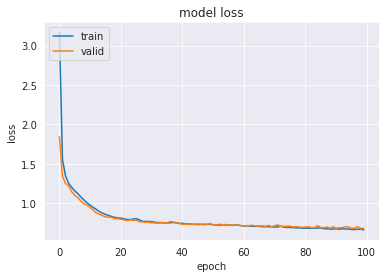

In [27]:
if not multi_epoch_analysis and samples_list == None: 
    
    results = train_nn_and_pred(0, 
                                X_train.values, 
                                X_valid.values, 
                                X_test.values, 
                                y_train.values, 
                                y_valid.values, 
                                y_test.values, 
                                pred_evaluation_dataset_valid_valid_split.values, 
                                pred_evaluation_dataset_valid_test_split.values, 
                                pred_evaluation_dataset_valid_train_split.values, 
                                pred_evaluation_dataset_test_valid_split.values, 
                                pred_evaluation_dataset_test_test_split.values, 
                                pred_evaluation_dataset_test_train_split.values, 
                                callback_names=['plot_losses_callback', 'early_stopping'], 
                                return_model=True) #, 'mcp_save'
    
    history = results[0]    
    
    scores_complete = results[1]
    scores_valid = scores_complete[0]
    scores = scores_complete[1]
    
    preds_complete = results[2]
    preds_valid = preds_complete[0]
    preds = preds_complete[1]
    
    model = results[3]
    
    x = PrettyTable()

    x.field_names = ["Error Name", "Valid Error Int", "Test Error Int"]

    for error, value in scores.items():

        x.add_row([error, value[0], value[1]])

    print(x)    
    
elif multi_epoch_analysis and samples_list == None: 

    indices = [i for i in range(len(X_train_list))]#[i for i in range(1,len(X_train_list)+1)]
    results_list = Parallel(n_jobs=n_jobs, 
                            verbose=11, 
                            backend='loky')(delayed(train_nn_and_pred)(index, 
                                                                      X_train.values, 
                                                                      X_valid.values, 
                                                                      X_test.values, 
                                                                      y_train.values, 
                                                                      y_valid.values, 
                                                                      y_test.values, 
                                                                      pred_evaluation_dataset_valid_valid_split.values, 
                                                                      pred_evaluation_dataset_valid_test_split.values, 
                                                                      pred_evaluation_dataset_valid_train_split.values, 
                                                                      pred_evaluation_dataset_test_valid_split.values, 
                                                                      pred_evaluation_dataset_test_test_split.values, 
                                                                      pred_evaluation_dataset_test_train_split.values, 
                                                                      callback_names=['early_stopping']) for index, 
                                                                                                               X_train, 
                                                                                                               X_valid, 
                                                                                                               X_test, 
                                                                                                               y_train, 
                                                                                                               y_valid, 
                                                                                                               y_test, 
                                                                                                               pred_evaluation_dataset_valid_valid_split, 
                                                                                                               pred_evaluation_dataset_valid_test_split, 
                                                                                                               pred_evaluation_dataset_valid_train_split, 
                                                                                                               pred_evaluation_dataset_test_valid_split, 
                                                                                                               pred_evaluation_dataset_test_test_split, 
                                                                                                               pred_evaluation_dataset_test_train_split in zip(indices, 
                                                                                                                                                                 X_train_list, 
                                                                                                                                                                 X_valid_list, 
                                                                                                                                                                 X_test_list, 
                                                                                                                                                                 y_train_list, 
                                                                                                                                                                 y_valid_list, 
                                                                                                                                                                 y_test_list, 
                                                                                                                                                                 pred_evaluation_dataset_valid_valid_split_list, 
                                                                                                                                                                 pred_evaluation_dataset_valid_test_split_list, 
                                                                                                                                                                 pred_evaluation_dataset_valid_train_split_list, 
                                                                                                                                                                 pred_evaluation_dataset_test_valid_split_list, 
                                                                                                                                                                 pred_evaluation_dataset_test_test_split_list, 
                                                                                                                                                                 pred_evaluation_dataset_test_train_split_list))      

    history_list = [result[0] for result in results_list]
    
    scores_list_complete = [result[1] for result in results_list]
    scores_list_valid = [scores[0] for scores in scores_list_complete]
    scores_list = [scores[1] for scores in scores_list_complete]
    
    preds_list_complete = [result[2] for result in results_list]
    preds_list_valid = [preds[0] for preds in preds_list_complete]
    preds_list = [preds[1] for preds in preds_list_complete]


    for i, history in enumerate(history_list):       
        try:
            # Create target Directory
            os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
        except FileExistsError:
            pass
        
        plt.plot(history[list(history.keys())[1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str((i+1)*each_epochs_save_lambda).zfill(3) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str((i+1)*each_epochs_save_lambda).zfill(3) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)   
        
elif not multi_epoch_analysis and  samples_list != None:
    
    indices = [i for i in range(len(samples_list))]#[i for i in range(1,len(X_train_list)+1)]
    results_list = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(delayed(train_nn_and_pred)(index, 
                                                                                                  X_train.sample(n=samples, random_state=RANDOM_SEED).values, 
                                                                                                  X_valid.values, 
                                                                                                  X_test.values, 
                                                                                                  y_train.sample(n=samples, random_state=RANDOM_SEED).values, 
                                                                                                  y_valid.values, 
                                                                                                  y_test.values, 
                                                                                                  pred_evaluation_dataset_valid_valid_split.values, 
                                                                                                  pred_evaluation_dataset_valid_test_split.values, 
                                                                                                  pred_evaluation_dataset_valid_train_split.values, 
                                                                                                  pred_evaluation_dataset_test_valid_split.values, 
                                                                                                  pred_evaluation_dataset_test_test_split.values, 
                                                                                                  pred_evaluation_dataset_test_train_split.values, 
                                                                                                  callback_names=['early_stopping']) for index, samples in zip(indices, samples_list))      
    
    history_list = [result[0] for result in results_list]
    
    scores_list_complete = [result[1] for result in results_list]
    scores_list_valid = [scores[0] for scores in scores_list_complete]
    scores_list = [scores[1] for scores in scores_list_complete]
    
    preds_list_complete = [result[2] for result in results_list]
    preds_list_valid = [preds[0] for preds in preds_list_complete]
    preds_list = [preds[1] for preds in preds_list_complete]

    for i, history in enumerate(history_list):       
        try:
            # Create target Directory
            os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
        except FileExistsError:
            pass
        
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)     
        

## Evaluate Interpretation Net

In [28]:
printer = None
if multi_epoch_analysis or samples_list != None:
    printer = scores_list_valid[-1]
else:
    printer = scores_valid
printer

{'MAE': [3.1436, 3.1336],
 'RMSE': [4.1358, 4.1231],
 'MAPE': [2.0859, 1.6876],
 'Accuracy': [0.0209, 0.0143],
 'Accuracy Multilabel': [0.0, 0.0],
 'MAE FV': [1.189, 1.2218],
 'RMSE FV': [1.6974, 1.7578],
 'MAPE FV': [0.7446, 0.861],
 'R2 FV': [0.6156, 0.649],
 'RAAE FV': [0.3425, 0.3278],
 'RMAE FV': [0.9756, 0.9409],
 'FD FV': [2.7525, 2.8851],
 'DTW FV': [10.549, 10.809],
 'STD FV PRED': [8.144930748429934, 7.950486081706943],
 'MEAN FV PRED': [-0.5986292883123002, 0.06420701508078144]}

In [29]:
printer = None
if multi_epoch_analysis or samples_list != None:
    printer = scores_list[-1]
else:
    printer = scores
printer

{'MAE': [3.1436, 3.1336],
 'RMSE': [4.1358, 4.1231],
 'MAPE': [2.0859, 1.6876],
 'Accuracy': [0.0209, 0.0143],
 'Accuracy Multilabel': [0.0, 0.0],
 'MAE FV': [0.9138, 0.9069],
 'RMSE FV': [1.4285, 1.4361],
 'MAPE FV': [0.7793, 0.7232],
 'R2 FV': [0.7009, 0.7111],
 'RAAE FV': [0.2933, 0.2842],
 'RMAE FV': [1.0989, 1.064],
 'FD FV': [0.8992, 0.8911],
 'DTW FV': [10.549, 5.4688],
 'STD FV PRED': [7.299899265815255, 7.226128507998315],
 'MEAN FV PRED': [-0.37133950182519804, 0.07179788985760817]}

    {'MAE': [2.4206, 2.4136],
     'RMSE': [4.4635, 4.4474],
     'MAPE': [39.7378, 15.9956],
     'Accuracy': [0.0398, 0.0399],
     'Accuracy Multilabel': [0.0, 0.0],
     'MAE FV': [12.483, 12.4179, 12.5016, 12.4378],
     'RMSE FV': [15.2681, 15.2061, 15.2788, 15.2182],
     'MAPE FV': [12.4203, 11.794, 15.5242, 10.9716],
     'R2 FV': [-3.4149, -3.4902, -3.4025, -3.4736],
     'RAAE FV': [1.6048, 1.6095, 1.6042, 1.6087],
     'RMAE FV': [3.2227, 3.2376, 3.1746, 3.1857],
     'FD FV': [20.2912, 20.3838, 20.1636, 20.2541],
     'DTW FV': [97.2094, 97.275, 96.9896, 97.0216],
     'STD FV PRED': [9.5580641448508,
      9.556464448607697,
      9.5580641448508,
      9.556464448607697],
     'MEAN FV PRED': [5.55908448430554,
      5.558512762925669,
      5.55908448430554,
      5.558512762925669]}

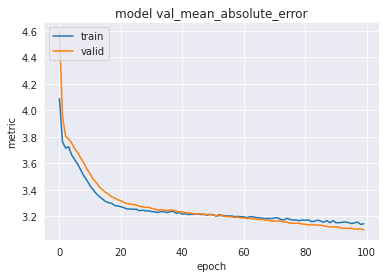

In [30]:
plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history[list(history.keys())[1]])
plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


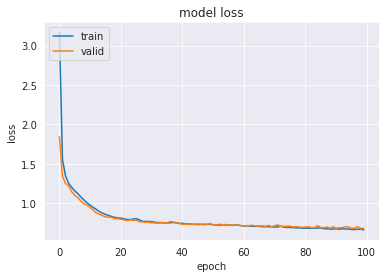

In [31]:
plt.plot(history['loss'])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

In [32]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_loss = []
    plot_history_metric = []
    plot_history_val_loss = []
    plot_history_val_metric = []
        
    for history in history_list:
        plot_history_loss.append(history['loss'][-1])
        plot_history_metric.append(history[list(history.keys())[1]][-1])

        if consider_labels_training or evaluate_with_real_function:
            plot_history_val_loss.append(history['val_loss'][-1])
            plot_history_val_metric.append(history[list(history.keys())[len(history.keys())//2+1]][-1])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


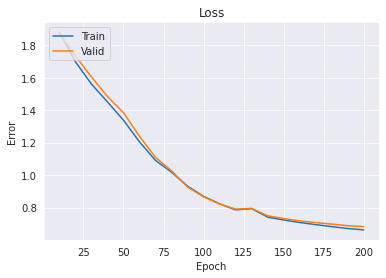

In [33]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_loss_df = pd.DataFrame(data=plot_history_loss, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_loss))])
    if consider_labels_training or evaluate_with_real_function:
        plot_history_val_loss_df = pd.DataFrame(data=plot_history_val_loss, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_val_loss))])
    
    plt.plot(plot_history_loss_df)
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(plot_history_val_loss_df)
    plt.title('Loss')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_total.eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


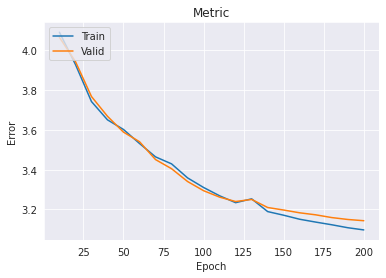

In [34]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_metric_df = pd.DataFrame(data=plot_history_metric, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_metric))])
    if consider_labels_training or evaluate_with_real_function:
        plot_history_val_metric_df = pd.DataFrame(data=plot_history_val_metric, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_val_metric))])
    
    plt.plot(plot_history_metric_df)
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(plot_history_val_metric_df)
    plt.title('Metric')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_total.eps')
    plt.show()

#### Structure Interpretation-Net Socres for Plotting

In [35]:
if multi_epoch_analysis and evaluate_with_real_function:
    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for index, scores_int in enumerate(scores_list):
        index = (index+1)*each_epochs_save_lambda

        if index == each_epochs_save_lambda:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list = pd.DataFrame([scores_int[score][0] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list = pd.DataFrame([scores_int[score][1] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])

            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
  
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list_new = pd.DataFrame([scores_int[score][0] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list_new = pd.DataFrame([scores_int[score][1] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)
            
            means_list = pd.concat([means_list, means_list_new],axis=1)  


elif multi_epoch_analysis and not evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for index, scores_int in enumerate(scores_list):
        index = (index+1)*each_epochs_save_lambda

        if index == each_epochs_save_lambda:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST E' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list_new = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list_new = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'means_function_test_pred_lambda_fv'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)  
            
            means_list = pd.concat([means_list, means_list_new],axis=1)  
    
elif not multi_epoch_analysis and samples_list != None and evaluate_with_real_function:
    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    

    for index, scores_int in enumerate(scores_list):
        index = samples_list[index]

        if index == samples_list[0]:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list = pd.DataFrame([scores_int[score][0] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list = pd.DataFrame([scores_int[score][1] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list_new = pd.DataFrame([scores_int[score][0] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list_new = pd.DataFrame([scores_int[score][1] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])

            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1) 
            
            means_list = pd.concat([means_list, means_list_new],axis=1)     
            
elif not multi_epoch_analysis and  samples_list != None and not evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for index, scores_int in enumerate(scores_list):
        index = samples_list[index]

        if index == samples_list[0]:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED S' + str(index), 'VALID POLY S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED S' + str(index), 'TEST POLY S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])

        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['VALID S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']], columns=['TEST S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list_new = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['VALID PRED S' + str(index), 'VALID POLY S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            scores_test_list_new = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']], columns=['TEST PRED S' + str(index), 'TEST POLY S' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])

            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)      
            
            means_list = pd.concat([means_list, means_list_new],axis=1)    
            
if multi_epoch_analysis:            
    path_scores_valid_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_multiepoch_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_test_multiepoch_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_scores_valid_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_int = './data/results/' + interpretation_network_string + filename + '/scores_test_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_stds_int = './data/results/' + interpretation_network_string + filename + '/stds_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_means_int = './data/results/' + interpretation_network_string + filename + '/means_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'


    scores_coeff_valid.to_csv(path_scores_valid_coef_int, sep=',')
    scores_coeff_test.to_csv(path_scores_test_coef_int, sep=',') 

    scores_valid_list.to_csv(path_scores_valid_int, sep=',')
    scores_test_list.to_csv(path_scores_test_int, sep=',')

    stds_list.to_csv(path_stds_int, sep=',')  
    means_list.to_csv(path_means_int, sep=',')  
elif samples_list != None:            
    path_scores_valid_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_samples_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_test_samples_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_scores_valid_int = './data/results/' + interpretation_network_string + filename + '/scores_samples_valid_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_int = './data/results/' + interpretation_network_string + filename + '/scores_samples_test_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_stds_int = './data/results/' + interpretation_network_string + filename + '/stds_samples_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_means_int = './data/results/' + interpretation_network_string + filename + '/means_samples_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'


    scores_coeff_valid.to_csv(path_scores_valid_coef_int, sep=',')
    scores_coeff_test.to_csv(path_scores_test_coef_int, sep=',') 

    scores_valid_list.to_csv(path_scores_valid_int, sep=',')
    scores_test_list.to_csv(path_scores_test_int, sep=',')

    stds_list.to_csv(path_stds_int, sep=',')  
    means_list.to_csv(path_means_int, sep=',')      

In [36]:
scores_valid_list

,VALID PRED E10,VALID PRED E20,VALID PRED E30,VALID PRED E40,VALID PRED E50,VALID PRED E60,VALID PRED E70,VALID PRED E80,VALID PRED E90,VALID PRED E100,VALID PRED E110,VALID PRED E120,VALID PRED E130,VALID PRED E140,VALID PRED E150,VALID PRED E160,VALID PRED E170,VALID PRED E180,VALID PRED E190,VALID PRED E200
MAE FV,2.516,2.325,2.152,1.990,1.857,1.661,1.486,1.376,1.241,1.160,1.101,1.059,1.065,1.004,0.981,0.961,0.948,0.935,0.922,0.914
RMSE FV,3.344,3.099,2.886,2.722,2.558,2.387,2.191,2.062,1.900,1.797,1.719,1.657,1.657,1.577,1.544,1.512,1.491,1.472,1.448,1.429
MAPE FV,2.994,2.875,2.282,1.257,1.005,1.278,0.929,0.833,1.131,0.851,0.730,0.771,0.930,0.751,0.735,0.731,0.825,0.788,0.766,0.779
R2 FV,-0.566,-0.511,-0.409,-0.201,-0.167,0.099,0.223,0.355,0.537,0.565,0.591,0.621,0.624,0.641,0.653,0.667,0.678,0.683,0.691,0.701
RAAE FV,0.825,0.779,0.730,0.669,0.637,0.551,0.484,0.439,0.386,0.363,0.345,0.332,0.334,0.319,0.312,0.306,0.302,0.299,0.296,0.293
RMAE FV,1.658,1.670,1.512,1.373,1.310,1.278,1.337,1.462,1.207,1.300,1.291,1.240,1.199,1.220,1.214,1.162,1.120,1.146,1.141,1.099
FD FV,2.716,2.543,2.349,2.158,1.939,1.698,1.461,1.300,1.137,1.054,1.005,0.971,0.984,0.932,0.917,0.912,0.906,0.896,0.892,0.899
DTW FV,28.438,26.892,24.942,22.791,21.014,19.019,17.285,16.341,14.912,14.023,13.346,12.811,12.771,12.039,11.678,11.360,11.139,10.930,10.721,10.549


In [37]:
scores_test_list

,TEST PRED E10,TEST PRED E20,TEST PRED E30,TEST PRED E40,TEST PRED E50,TEST PRED E60,TEST PRED E70,TEST PRED E80,TEST PRED E90,TEST PRED E100,TEST PRED E110,TEST PRED E120,TEST PRED E130,TEST PRED E140,TEST PRED E150,TEST PRED E160,TEST PRED E170,TEST PRED E180,TEST PRED E190,TEST PRED E200
MAE FV,2.567,2.365,2.178,2.015,1.885,1.681,1.504,1.403,1.268,1.196,1.138,1.088,1.087,1.019,0.992,0.968,0.949,0.933,0.918,0.907
RMSE FV,3.455,3.166,2.910,2.732,2.576,2.392,2.184,2.063,1.920,1.824,1.758,1.701,1.695,1.611,1.573,1.536,1.507,1.483,1.456,1.436
MAPE FV,2.045,1.397,1.103,1.023,0.976,0.942,0.924,0.957,0.853,0.817,0.787,0.781,0.817,0.765,0.767,0.760,0.766,0.751,0.738,0.723
R2 FV,-0.961,-0.869,-0.701,-0.347,-0.199,0.191,0.320,0.396,0.516,0.537,0.560,0.590,0.598,0.620,0.635,0.657,0.674,0.684,0.697,0.711
RAAE FV,0.842,0.794,0.741,0.676,0.634,0.536,0.474,0.439,0.391,0.372,0.356,0.339,0.337,0.321,0.312,0.304,0.297,0.293,0.288,0.284
RMAE FV,1.784,1.717,1.518,1.375,1.287,1.264,1.250,1.383,1.184,1.278,1.285,1.257,1.210,1.231,1.220,1.153,1.105,1.122,1.110,1.064
FD FV,2.709,2.539,2.355,2.176,1.979,1.735,1.516,1.367,1.196,1.118,1.064,1.017,1.026,0.964,0.944,0.929,0.919,0.903,0.891,0.891
DTW FV,18.159,16.758,15.010,13.595,12.302,10.515,8.907,8.054,6.990,6.571,6.271,6.013,6.132,5.783,5.673,5.628,5.592,5.517,5.465,5.469


#### Load Lambda Scores for Plotting

In [38]:
path_scores_valid_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_scores_test_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_stds_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/stds_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_means_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/means_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'


df_mean_scores_valid_lambda = pd.read_csv(path_scores_valid_lambda, sep=',', index_col=0)
df_mean_scores_test_lambda = pd.read_csv(path_scores_test_lambda, sep=',', index_col=0)
df_stds_lambda = pd.read_csv(path_stds_lambda, sep=',', index_col=0)
df_means_lambda = pd.read_csv(path_means_lambda, sep=',', index_col=0)


In [39]:
df_mean_scores_test_lambda

,TEST PRED E10,TEST POLY E10,TEST POLY PRED E10,TEST LSTSQ E10,TEST PRED E20,TEST POLY E20,TEST POLY PRED E20,TEST LSTSQ E20,TEST PRED E30,TEST POLY E30,...,TEST POLY PRED E180,TEST LSTSQ E180,TEST PRED E190,TEST POLY E190,TEST POLY PRED E190,TEST LSTSQ E190,TEST PRED E200,TEST POLY E200,TEST POLY PRED E200,TEST LSTSQ E200
MAE FV,6.538,6.538,0.004,1.512,6.208,6.208,0.004,1.512,5.815,5.815,...,0.026,1.512,2.600,2.599,0.028,1.512,2.572,2.570,0.030,1.512
RMSE FV,7.676,7.676,0.005,1.887,7.354,7.354,0.005,1.887,6.971,6.971,...,0.034,1.887,3.436,3.434,0.036,1.887,3.397,3.395,0.038,1.887
MAPE FV,1.130,1.130,0.155,1.540,1.249,1.249,0.042,1.540,1.399,1.398,...,0.067,1.540,1.970,1.962,0.059,1.540,1.958,1.949,0.060,1.540
R2 FV,-3.222,-3.222,0.997,0.844,-2.708,-2.707,0.999,0.844,-2.119,-2.120,...,0.999,0.844,0.419,0.419,0.999,0.844,0.427,0.427,0.999,0.844
RAAE FV,1.552,1.552,0.034,0.309,1.453,1.453,0.024,0.309,1.333,1.333,...,0.013,0.309,0.549,0.549,0.014,0.309,0.544,0.544,0.014,0.309
RMAE FV,2.065,2.066,0.101,0.897,2.038,2.038,0.079,0.897,1.992,1.992,...,0.040,0.897,1.524,1.523,0.041,0.897,1.515,1.514,0.042,0.897
FD FV,12.661,12.660,0.009,3.320,12.245,12.246,0.010,3.320,11.759,11.761,...,0.067,3.320,5.761,5.759,0.071,3.320,5.668,5.666,0.075,3.320
DTW FV,63.631,63.634,0.044,14.629,60.294,60.295,0.039,14.629,56.316,56.318,...,0.258,14.629,23.575,23.565,0.273,14.629,23.283,23.271,0.287,14.629


In [40]:
df_stds_lambda

,E10,E20,E30,E40,E50,E60,E70,E80,E90,E100,E110,E120,E130,E140,E150,E160,E170,E180,E190,E200
STD FV TRAIN REAL,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697,4.697
STD FV VALID REAL,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265,4.265
STD FV VALID PRED,0.153,0.180,0.222,0.284,0.374,0.504,0.675,0.866,1.067,1.265,1.452,1.624,1.779,1.916,2.037,2.141,2.233,2.312,2.382,2.444
STD FV VALID POLY,0.152,0.180,0.222,0.285,0.374,0.504,0.674,0.865,1.066,1.265,1.451,1.623,1.778,1.915,2.036,2.140,2.231,2.311,2.381,2.443
STD FV VALID LSTSQ,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853,3.853
STD FV TEST REAL,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969,4.969
STD FV TEST PRED,0.143,0.184,0.240,0.321,0.431,0.586,0.788,1.012,1.247,1.479,1.697,1.897,2.076,2.235,2.375,2.496,2.601,2.693,2.775,2.846
STD FV TEST POLY,0.144,0.183,0.240,0.321,0.431,0.587,0.788,1.012,1.248,1.479,1.697,1.897,2.077,2.236,2.376,2.497,2.602,2.694,2.775,2.847
STD FV TEST LSTSQ,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620,4.620


In [41]:
df_means_lambda

,E10,E20,E30,E40,E50,E60,E70,E80,E90,E100,E110,E120,E130,E140,E150,E160,E170,E180,E190,E200
MEAN FV TRAIN REAL,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182,0.182
MEAN FV VALID REAL,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214,0.214
MEAN FV VALID PRED,0.177,0.239,0.352,0.512,0.694,0.777,0.703,0.620,0.549,0.489,0.439,0.400,0.371,0.348,0.332,0.319,0.308,0.300,0.293,0.287
MEAN FV VALID POLY,0.177,0.239,0.353,0.511,0.694,0.777,0.703,0.620,0.549,0.489,0.439,0.400,0.371,0.348,0.332,0.318,0.308,0.300,0.293,0.287
MEAN FV VALID LSTSQ,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221,0.221
MEAN FV TEST REAL,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131,0.131
MEAN FV TEST PRED,0.156,0.202,0.299,0.440,0.602,0.668,0.578,0.483,0.405,0.343,0.296,0.262,0.240,0.225,0.216,0.209,0.204,0.201,0.198,0.196
MEAN FV TEST POLY,0.157,0.202,0.299,0.440,0.602,0.668,0.577,0.483,0.405,0.343,0.295,0.261,0.240,0.225,0.216,0.209,0.204,0.201,0.198,0.197
MEAN FV TEST LSTSQ,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133,0.133


### Select Columns to Plot

In [42]:
if multi_epoch_analysis:
    'Reduce the dfs to equal keys for plotting comparison'
    plot_cols = df_mean_scores_test_lambda.index#scores_df.index.intersection(df_mean_scores_test_lambda.index)
    scores_lambda = df_mean_scores_test_lambda.loc[plot_cols]
    scores_int = scores_test_list.loc[plot_cols]    
elif samples_list != None:
    'Reduce the dfs to equal keys for plotting comparison'
    plot_cols = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV']
    scores_int = scores_test_list.loc[plot_cols] 
    scores_lambda = df_mean_scores_test_lambda.loc[plot_cols].iloc[:,-4:]

In [43]:
print_head = None
if multi_epoch_analysis or samples_list != None:
    print_head = scores_int
print_head

,TEST PRED E10,TEST PRED E20,TEST PRED E30,TEST PRED E40,TEST PRED E50,TEST PRED E60,TEST PRED E70,TEST PRED E80,TEST PRED E90,TEST PRED E100,TEST PRED E110,TEST PRED E120,TEST PRED E130,TEST PRED E140,TEST PRED E150,TEST PRED E160,TEST PRED E170,TEST PRED E180,TEST PRED E190,TEST PRED E200
MAE FV,2.567,2.365,2.178,2.015,1.885,1.681,1.504,1.403,1.268,1.196,1.138,1.088,1.087,1.019,0.992,0.968,0.949,0.933,0.918,0.907
RMSE FV,3.455,3.166,2.910,2.732,2.576,2.392,2.184,2.063,1.920,1.824,1.758,1.701,1.695,1.611,1.573,1.536,1.507,1.483,1.456,1.436
MAPE FV,2.045,1.397,1.103,1.023,0.976,0.942,0.924,0.957,0.853,0.817,0.787,0.781,0.817,0.765,0.767,0.760,0.766,0.751,0.738,0.723
R2 FV,-0.961,-0.869,-0.701,-0.347,-0.199,0.191,0.320,0.396,0.516,0.537,0.560,0.590,0.598,0.620,0.635,0.657,0.674,0.684,0.697,0.711
RAAE FV,0.842,0.794,0.741,0.676,0.634,0.536,0.474,0.439,0.391,0.372,0.356,0.339,0.337,0.321,0.312,0.304,0.297,0.293,0.288,0.284
RMAE FV,1.784,1.717,1.518,1.375,1.287,1.264,1.250,1.383,1.184,1.278,1.285,1.257,1.210,1.231,1.220,1.153,1.105,1.122,1.110,1.064
FD FV,2.709,2.539,2.355,2.176,1.979,1.735,1.516,1.367,1.196,1.118,1.064,1.017,1.026,0.964,0.944,0.929,0.919,0.903,0.891,0.891
DTW FV,18.159,16.758,15.010,13.595,12.302,10.515,8.907,8.054,6.990,6.571,6.271,6.013,6.132,5.783,5.673,5.628,5.592,5.517,5.465,5.469


### Generate Comparison Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

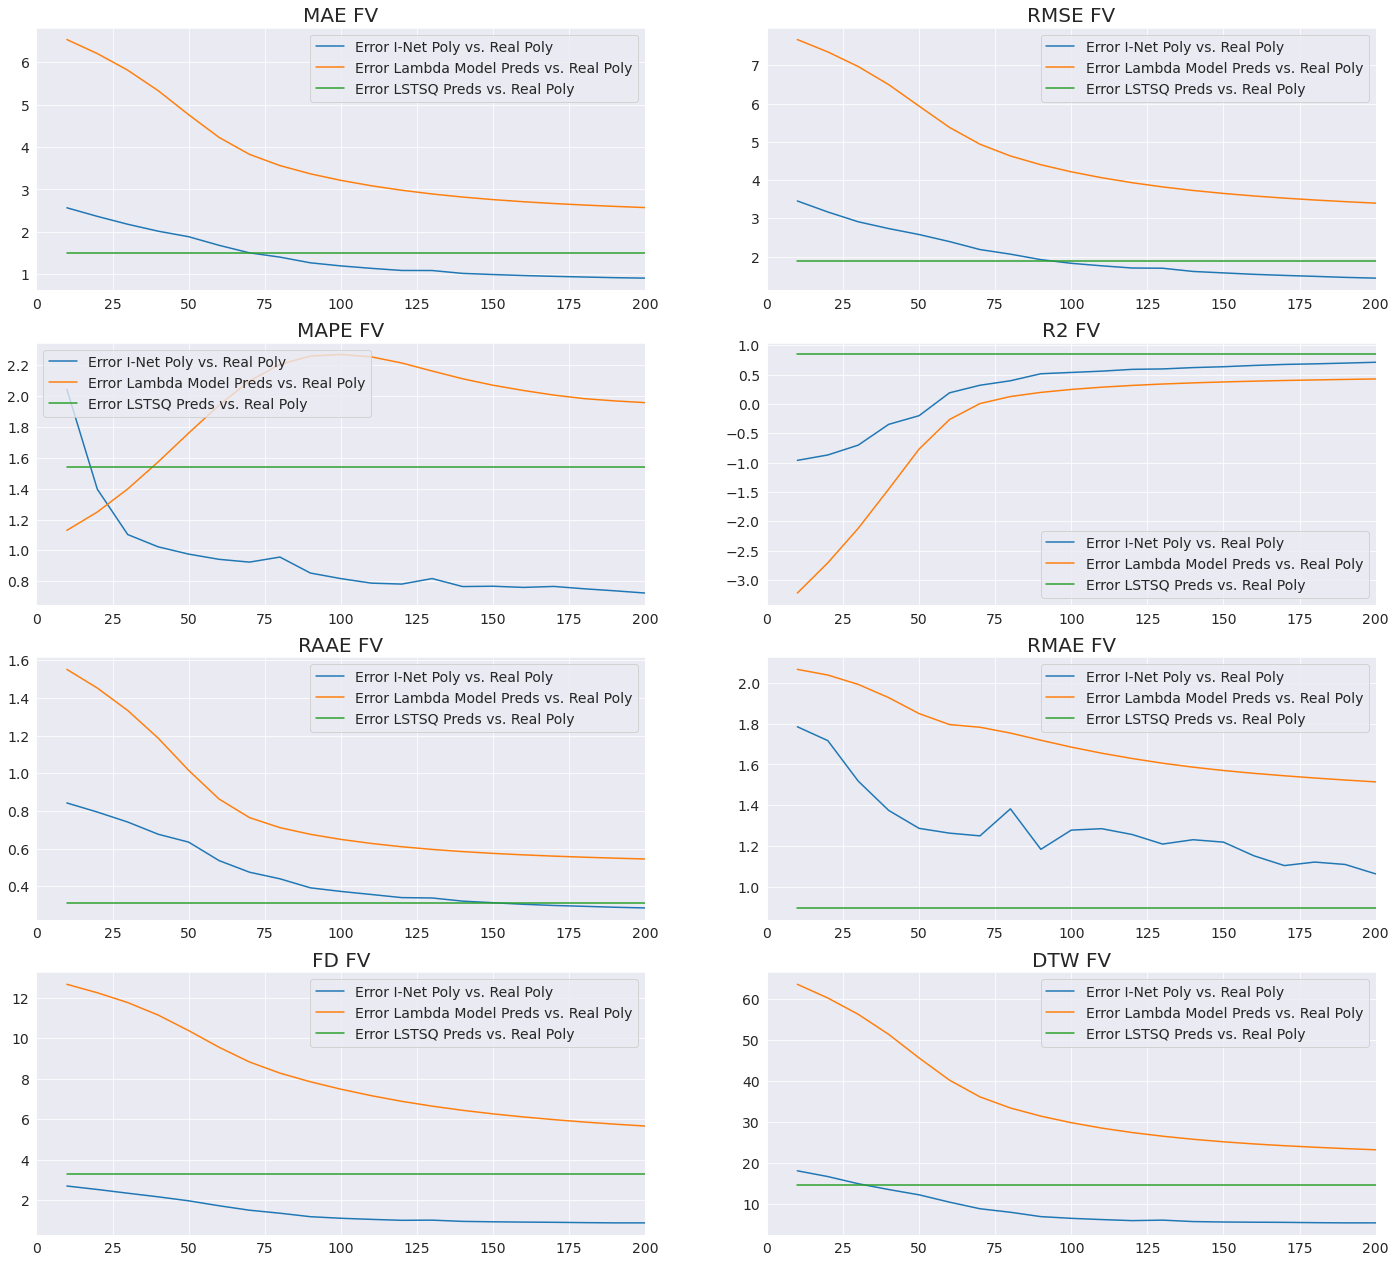

In [44]:
#Generate plot TEST PRED
try:
    # Create target Directory
    os.mkdir('./data/plotting/' + interpretation_network_string + filename + '/')
except FileExistsError:
    pass

if multi_epoch_analysis and evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_lambda.index:

        vals_int_real = scores_int.loc[index].values
        vals_lambda_real = scores_lambda.loc[index].values[::4]
        vals_lambda_lstsq = scores_lambda.loc[index].values[3::4]

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_int_real, label='Error I-Net Poly vs. Real Poly')
        ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
        ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, epochs_lambda])
        
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   
            
        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_REAL_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
elif multi_epoch_analysis and not evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_lambda.index:

        vals_int_poly = scores_int.loc[index].values[1::2]
        vals_int_preds = scores_int.loc[index].values[::2]
        vals_lambda_poly_pred = scores_lambda.loc[index].values[2::4]

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
        ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
        ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, epochs_lambda])
        
        
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   
                    
        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()

elif samples_list != None and evaluate_with_real_function:
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_int.index:

        vals_int_real = scores_int.loc[index].values
        vals_lambda_real = np.concatenate([scores_lambda.loc[index].values[::4] for i in samples_list], axis=None)
        vals_lambda_lstsq = np.concatenate([scores_lambda.loc[index].values[3::4] for i in samples_list], axis=None)

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot(samples_list, vals_int_real, label='Error I-Net Poly vs. Real Poly')
        ax.plot(samples_list, vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
        ax.plot(samples_list, vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, samples_list[-1]])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   

        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file    
    
    plt.savefig(path, format='eps')
    plt.show()

elif samples_list != None and not evaluate_with_real_function:
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_int.index:

        vals_int_poly = scores_int.loc[index].values[1::2]
        vals_int_preds = scores_int.loc[index].values[::2]
        vals_lambda_poly_pred = np.concatenate([scores_lambda.loc[index].values[2::4] for i in samples_list], axis=None)
        
        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot(samples_list, vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
        ax.plot(samples_list, vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
        ax.plot(samples_list, vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, samples_list[-1]])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   

        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file    
    
    plt.savefig(path, format='eps')
    plt.show()
        

In [45]:
#vals_int_poly

In [46]:
#vals_int_preds

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


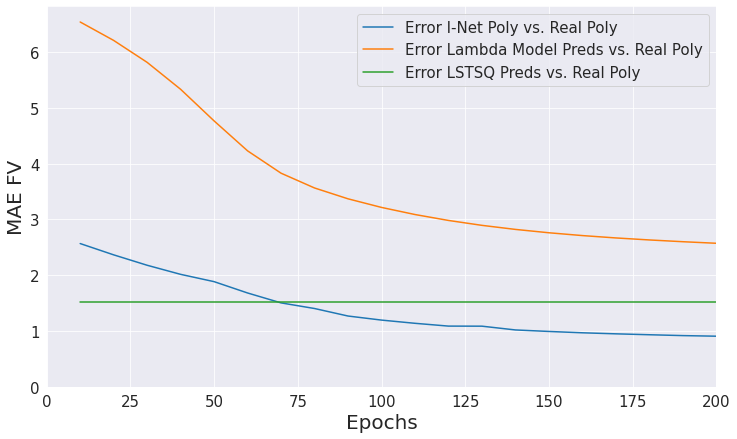

In [47]:
if multi_epoch_analysis and evaluate_with_real_function:
    index = 'MAE FV'

    vals_int_real = scores_int.loc[index].values
    vals_lambda_real = scores_lambda.loc[index].values[::4]
    vals_lambda_lstsq = scores_lambda.loc[index].values[3::4]


    fig, ax = plt.subplots(figsize=(12, 7))
    #ax.set_title('Accuracy Evaluation')

    ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_int_real, label='Error I-Net Poly vs. Real Poly')
    ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
    ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')

    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Epochs', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, epochs_lambda])
    ax.set_ylim(bottom=0)
    #ax.set_xticks(np.arange(0, epochs, step=1))
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_REAL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file 
    
    fig.savefig(path, format='eps')
    
elif multi_epoch_analysis and not evaluate_with_real_function:
       
    index = 'MAE FV'

    vals_int_poly = scores_int.loc[index].values[1::2]
    vals_int_preds = scores_int.loc[index].values[::2]
    vals_lambda_poly_pred = scores_lambda.loc[index].values[2::4]


    fig, ax = plt.subplots(figsize=(12, 7))
    #ax.set_title('Accuracy Evaluation')

    ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
    ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
    ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')

    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Epochs', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, epochs_lambda])
    ax.set_ylim(bottom=0)
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_MODEL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
        
    fig.savefig(path, format='eps')

elif samples_list != None and evaluate_with_real_function:
    index = 'MAE FV'

    vals_int_real = scores_int.loc[index].values
    vals_lambda_real = np.concatenate([scores_lambda.loc[index].values[::4] for i in samples_list], axis=None)
    vals_lambda_lstsq = np.concatenate([scores_lambda.loc[index].values[3::4] for i in samples_list], axis=None)
        
    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.plot(samples_list, vals_int_real, label='Error I-Net Poly vs. Real Poly')
    ax.plot(samples_list, vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
    ax.plot(samples_list, vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        
    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Training Set Size I-Net', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)   
    
    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, samples_list[-1]])
    ax.set_ylim(bottom=0)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list_' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    fig.savefig(path, format='eps')

elif samples_list != None and not evaluate_with_real_function:
    index = 'MAE FV'


    vals_int_poly = scores_int.loc[index].values[1::2]
    vals_int_preds = scores_int.loc[index].values[::2]
    vals_lambda_poly_pred = np.concatenate([scores_lambda.loc[index].values[2::4] for i in samples_list], axis=None)

        
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(samples_list, vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
    ax.plot(samples_list, vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
    ax.plot(samples_list, vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
    
    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Training Set Size I-Net', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)   
    
    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, samples_list[-1]])
    ax.set_ylim(bottom=0)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list_' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
        
    fig.savefig(path, format='eps')


#### Generate and Analyze Predictions for Random Function

In [57]:
### Philipp Edit

#Load polynomials with error
#path_y_data = './data/saved_polynomial_lists/y_sample' + str(interpretation_dataset_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step) + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + error_method + str(error_factor) + training_string + '.pkl'
path_y_data = './data/saved_polynomial_lists/y_sample' + str(2000) + '_train_' + str(250) + '_variables_' + str(1) + '_degree_' + str(5) + '_sparsity_' + str(6) + '_astep_' + str(0.1) + '_amin_' + str(-10) + '_amax_' + str(10) + '_xstep_' + str(0.0001) + '_xmin_' + str(-1) + '_xmax_' + str(1) + '_standarddeviationrange_' + str(0.1) + '_same' + '.pkl'
with open(path_y_data, 'rb') as f:
    y_noisy_data_list = pickle.load(f)

In [3]:
a = [1,2,3]
b = [4,5,6]

c = a
c.extend(b)
print(c)

[1, 2, 3, 4, 5, 6]


In [5]:
import numpy as np

In [8]:
[a[0] for a in [[[1,2,3], [4,5,6]],
               [[2,4,6], [8,10,12]]]]

[[1, 2, 3], [2, 4, 6]]

In [7]:
a = np.array([[1,2,3],
             [2,4,6]])

b = np.array([[4,5],
             [8,10]])



array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10]])

In [9]:
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold


In [ ]:
columns = list_of_monomial_identifiers
columns.extend(variable_values_test)

coefficients = [y_noisy_data[0].values for y_noisy_data in y_noisy_data_list]
noisy_fvs_test = [train_test_split(y_noisy_data[1].values, test_size=0.25, random_state=RANDOM_SEED)[1] for y_noisy_data in y_noisy_data_list]

y_noisy_data_adjusted = pd.DataFrame(data=np.hstack([coefficients, noisy_fvs_test]), columns=columns)

y_noisy_data_adjusted = y_noisy_data_adjusted.sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)

_, y_noisy_data_adjusted_test_split = train_test_split(y_noisy_data_adjusted, test_size=0.25, random_state=RANDOM_SEED)


In [58]:
y_noisy_data_list[0]

[0    6.300
 1   -7.200
 2   -9.400
 3    8.900
 4   -3.000
 5   -3.800
 Name: 0, dtype: float64,
          0
 0    5.478
 1    5.106
 2    9.982
 3    3.117
 4   -4.665
 ..     ...
 245  0.169
 246 -3.276
 247  5.503
 248 -1.519
 249  4.203
 
 [250 rows x 1 columns]]

In [53]:
if multi_epoch_analysis:
    plot_preds = preds_list[-1]
    plot_eval = pred_evaluation_dataset_test_test_split_list[-1]
elif samples_list != None:
    plot_preds = preds_list[-1]
    plot_eval = pred_evaluation_dataset_test_test_split
else:
    plot_preds = preds
    plot_eval = pred_evaluation_dataset_test_test_split

x_vars = ['x' + str(i) for i in range(1, n+1)]a

columns = x_vars.copy()
columns.append('FVs')

columns_single = x_vars.copy()
columns_single.extend(['Real Poly FVs (Target)', 'Int Pred Poly FVs', 'Lambda Preds'])

eval_size_plot = plot_preds[2].shape[1]
rand_index = random.randint(0, plot_preds[2].shape[0]-1) #42
vars_plot = np.column_stack([variable_values_test[::,i] for i in range(n)])
plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, plot_preds[2][rand_index], plot_preds[3][rand_index], plot_eval.values[rand_index]]), columns=columns_single)

vars_plot_all_preds = np.append(np.append(vars_plot, vars_plot, axis=0), vars_plot, axis=0)
preds_plot_all = np.append(np.append(plot_preds[2][rand_index], plot_preds[3][rand_index], axis=0), plot_eval.values[rand_index], axis=0)

# PHILIPP EDIT

# Split noisy polynomials and get one polynomial with random index 
ignore, y_noisy_data_test_split = train_test_split(y_noisy_data_list, test_size=0.25, random_state=RANDOM_SEED)
random_split = y_noisy_data_test_split[rand_index][1][0]
ignore, noisy_poly = train_test_split(random_split, test_size=0.25, random_state=RANDOM_SEED)

# Create plot data for noisy polynomial
vars_plot_all_preds_noisy = np.append(np.append(np.append(vars_plot, vars_plot, axis=0), vars_plot, axis=0), vars_plot, axis=0)
preds_plot_all_noisy = np.append(np.append(np.append(plot_preds[2][rand_index], plot_preds[3][rand_index], axis=0), plot_eval.values[rand_index], axis=0), noisy_poly, axis=0)

# Create plot data for lstsq polynomial
#vars_plot_all_preds_lstsq = np.append(np.append(np.append(vars_plot, vars_plot, axis=0), vars_plot, axis=0), vars_plot, axis=0)
#preds_plot_all_lstsq = np.append(np.append(np.append(plot_preds[2][rand_index], plot_preds[3][rand_index], axis=0), plot_eval.values[rand_index], axis=0), plot_preds[1][rand_index], axis=0)

### PHILIPP EDIT - add noisy_str

if evaluate_with_real_function:
    real_str = np.array(['Real Poly FVs (Target)' for i in range(eval_size_plot)])
    int_str = np.array(['Int Pred Poly FVs' for i in range(eval_size_plot)])
    lambda_str = np.array(['Lambda Preds' for i in range(eval_size_plot)])
    ###PHILIPP
    noisy_str = np.array(['Noisy Poly FVs' for i in range(eval_size_plot)])
    lstsq_str = np.array(['LSTSQ Preds' for i in range(eval_size_plot)])
    #Add Lambda Poly Preds LSTSQ
else:
    real_str = np.array(['Lambda Poly FVs (Target)' for i in range(eval_size_plot)])
    int_str = np.array(['Int Pred Poly FVs' for i in range(eval_size_plot)])
    lambda_str = np.array(['Lambda Preds' for i in range(eval_size_plot)])
    #Add Lambda Poly Preds
    
identifier = np.concatenate([real_str, int_str, lambda_str])
#Philipp Edit
identifier_noisy = np.concatenate([real_str, int_str, lambda_str, noisy_str])
identifier_lstsq = np.concatenate([real_str, int_str, lambda_str, lstsq_str])

plot_data = pd.DataFrame(data=np.column_stack([vars_plot_all_preds, preds_plot_all]), columns=columns)
plot_data['Identifier'] = identifier

#Philipp Edit - Noise
plot_data_noisy = pd.DataFrame(data=np.column_stack([vars_plot_all_preds_noisy, preds_plot_all_noisy]), columns=columns)
plot_data_noisy['Identifier'] = identifier_noisy

#Philipp Edit - LSTSQ
#plot_data_lstsq = pd.DataFrame(data=np.column_stack([vars_plot_all_preds_lstsq, preds_plot_all_lstsq]), columns=columns)
#plot_data_lstsq['Identifier'] = identifier_lstsq


In [54]:
rand_index

327

In [51]:
plot_data.head()

,x1,FVs,Identifier
0,0.752,9.043,Real Poly FVs (Target)
1,-0.895,18.450,Real Poly FVs (Target)
2,-0.749,16.244,Real Poly FVs (Target)
3,0.723,8.780,Real Poly FVs (Target)
4,0.249,8.815,Real Poly FVs (Target)


In [52]:
plot_data_noisy.tail(65)

,x1,FVs,Identifier
187,0.449,8.302,Lambda Preds
188,-0.876,15.517,Lambda Preds
189,0.752,3.079,Noisy Poly FVs
190,-0.895,6.498,Noisy Poly FVs
191,-0.749,2.538,Noisy Poly FVs
...,...,...,...
247,-0.339,2.852,Noisy Poly FVs
248,0.063,6.743,Noisy Poly FVs
249,-0.425,2.167,Noisy Poly FVs
250,0.449,7.253,Noisy Poly FVs


In [55]:
plot_data_lstsq.tail(65)

,x1,FVs,Identifier
187,0.449,8.302,Lambda Preds
188,-0.876,15.517,Lambda Preds
189,0.752,-6.474,LSTSQ Preds
190,-0.895,-3.087,LSTSQ Preds
191,-0.749,-0.696,LSTSQ Preds
...,...,...,...
247,-0.339,1.459,LSTSQ Preds
248,0.063,0.497,LSTSQ Preds
249,-0.425,1.375,LSTSQ Preds
250,0.449,-2.244,LSTSQ Preds


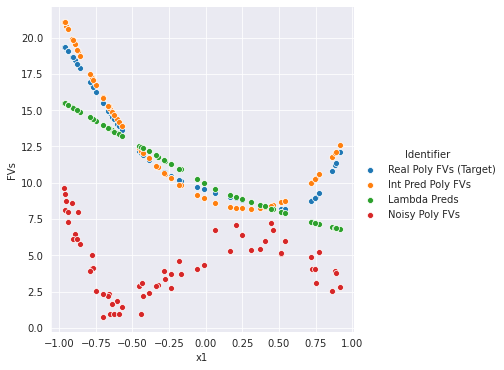

In [57]:
### Philipp Edit

#Plot including polynomial with error

pp_noisy = sns.pairplot(data=plot_data_noisy,
                  hue='Identifier',
                  y_vars=['FVs'],
                  x_vars=x_vars,
                  height=5)


In [ ]:
pp1 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  y_vars=['FVs'],
                  x_vars=x_vars,
                  height=5)

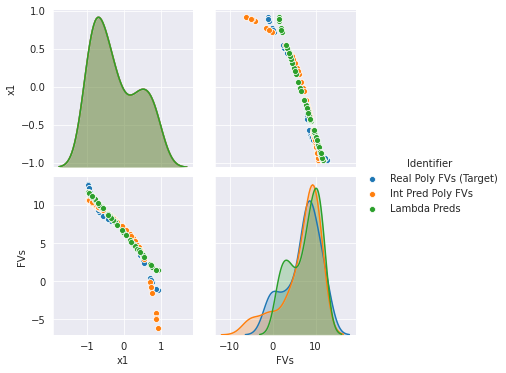

In [67]:
pp2 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  #y_vars=['FVs'],
                  #x_vars=x_vars
                 )

In [ ]:
pp3 = sns.pairplot(data=plot_data_single,
                  #kind='reg',
                  y_vars=['Real Poly FVs (Target)', 'Int Pred Poly FVs', 'Lambda Preds'],
                  x_vars=x_vars)

In [ ]:
if evaluate_with_real_function:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_REAL_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')
else:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_PRED_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')    
    

### Single Network Analysis

In [ ]:
if not multi_epoch_analysis and samples_list == None: 
    #%%script false --no-raise-error
    path_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n)+ '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_val_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_val_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'


    loss_df_lambda = pd.read_csv(path_loss, sep=',')
    metric_df_lambda = pd.read_csv(path_metric, sep=',')
    val_loss_df_lambda = pd.read_csv(path_val_loss, sep=',')
    val_metric_df_lambda = pd.read_csv(path_val_metric, sep=',')


In [ ]:
if not multi_epoch_analysis and samples_list == None: 

    #%%script false --no-raise-error
    adjustment_threshold_metric = 0

    metric_df_adjusted = metric_df_lambda.copy(deep=True)
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])

    val_metric_df_adjusted = val_metric_df_lambda.copy(deep=True)
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])


    plt.plot(metric_df_adjusted.describe().loc['mean'].values)
    plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
    #plt.plot(random_network[2].history['val_metric'])
    plt.title('model metric')
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
if not multi_epoch_analysis and samples_list == None: 
    #%%script false --no-raise-error
    adjustment_threshold_loss = 1000

    loss_df_adjusted = loss_df_lambda.copy(deep=True)
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])

    val_loss_df_adjusted = val_loss_df_lambda.copy(deep=True)
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])


    plt.plot(loss_df_adjusted.describe().loc['mean'].values)
    plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
    #plt.plot(random_network[2].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()


In [ ]:
if not multi_epoch_analysis and samples_list == None: 
    preds = model.predict(X_test)
    preds_rounded = np.round(preds, 1)
    #preds_true = pd.DataFrame(data=[np.round(preds, 1), y_test.values])
    for pred, y in tqdm(zip(preds_rounded, y_test.values)):
        if (pred == y).all():
            print(pred)
    
    #print(preds_rounded)
    #print(y_test.values)

In [ ]:
#summarize history for loss
if not multi_epoch_analysis and samples_list == None: 
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    #plt.plot(random_network[2].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/loss_' + interpretation_network_string + filename + '.png')
    plt.show()
    

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = []
for i in range(y_test.shape[0]):
    random_polynomial = list(random_product([i*a_step for i in range(int(a_min*10**int(-np.log10(a_step))), int(a_max*10**int(-np.log10(a_step))))], repeat=nCr(n+d, d)))
    list_of_random_polynomials.append(random_polynomial)

In [ ]:
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
results_list_test = parallel(delayed(calculate_function_values_from_polynomial)(true_value_test, random_value_test, variable_values_test) for true_value_test, random_value_test in zip(y_test.values, list_of_random_polynomials))        
del parallel   
    
true_fv_test = np.array([result[0] for result in results_list_test])
random_fv_test = np.array([result[1] for result in results_list_test])

true_fv_test_with_variable_values = np.array([result[2] for result in results_list_test])
random_fv_test_with_variable_values = np.array([result[3] for result in results_list_test])

In [ ]:
print('Benchmark Error Coefficients: ' + str(np.round(mean_absolute_error(y_test, list_of_random_polynomials), 4)))

In [ ]:
print('Benchmark Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))